# Optimizing InPost Logistics with Neural Networks and Machine Learning
Author: Andrii Zapukhlyi

## Objective

The goal of this project is to optimize InPost logistics by forecasting the daily number of parcel shipments using multiple data sources. These include historical shipment volumes, client-provided forecasts, date-specific attributes, and weather conditions. By developing a robust predictive model, this solution aims to enhance planning accuracy, streamline logistics operations, and support data-driven decision-making.

## Solution

The solution involves preprocessing, visualizing, and analyzing the data, followed by the development of various time-series forecasting models. These models will include SARIMA, Prophet, Gradient Boosting algorithms, Tree-based models, and Artificial Neural Networks.

## Dataset Overview
The data consists of 4 datasets containing various information from January 2021 to September 2023:

- dimDates.csv: Includes information about days, such as year, month, day of the week, holiday indicators, and other date-related attributes.
- Posting_volumes.parquet: Contains parcel volume data from January 2021 to September 2023 with separated X client.
- X_ClientORDERS.xlsx: Provides X client's predictions for parcel volumes starting from January 2023.
- Folder Temp: Includes daily weather data for the same period.

In [207]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings, os, random, itertools, logging, cmdstanpy
from statsmodels.tools.sm_exceptions import ConvergenceWarning
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from pmdarima import auto_arima
from scipy.stats import shapiro, boxcox
import statsmodels.api as sm_api
from scipy.special import inv_boxcox
from prophet import Prophet
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
import lightgbm as lgb
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
from torch import optim
from tqdm import tqdm


seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)
random.seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

warnings.filterwarnings("ignore", category=ConvergenceWarning) # Turn off warnings for SARIMA
warnings.filterwarnings("ignore", category=UserWarning) # Turn off warnings for SARIMA
warnings.simplefilter("ignore", FutureWarning) # Turn off warnings for SARIMA
logging.getLogger('cmdstanpy').setLevel(logging.WARNING) # Turn off warnings for Prophet

## dimDates.csv - Data preprocessing

In [2]:
df1 = pd.read_csv("data/dimDates.csv", sep = ";")
df1

,datePk,dateId,dateYear,dateYearISO,dateMonthYear,dateWeekYearISO,dateQuarterYear,dateMonth,dateDay,dateDaySuffix,...,courierBillingPeriodStartDateFk,courierBillingPeriodEndDateFk,xlsDate,dwhDateFrom,dwhDateTo,dwhCurrRec,dwhAuditCd,dwhAuditCp,dwhAuditMd,dwhAuditMp
0,20201004,2020-10-04,2020,2020,10.2020,T40-2020,Q4-2020,10,4,th,...,20201001,20201015,44108,1900-01-01,9999-12-31,1,2020-07-03 13:51:15.673,1904719,2020-07-03 13:51:15.673,1904719
1,20200810,2020-08-10,2020,2020,8.2020,T33-2020,Q3-2020,8,10,th,...,20200801,20200815,44053,1900-01-01,9999-12-31,1,2020-07-03 13:51:15.673,1904719,2020-07-03 13:51:15.673,1904719
2,20200930,2020-09-30,2020,2020,9.2020,T40-2020,Q3-2020,9,30,th,...,20200916,20200930,44104,1900-01-01,9999-12-31,1,2020-07-03 13:51:15.673,1904719,2020-07-03 13:51:15.673,1904719
3,20200521,2020-05-21,2020,2020,5.2020,T21-2020,Q2-2020,5,21,st,...,20200516,20200531,43972,1900-01-01,9999-12-31,1,2020-07-03 13:51:15.673,1904719,2020-07-03 13:51:15.673,1904719
4,20200527,2020-05-27,2020,2020,5.2020,T22-2020,Q2-2020,5,27,th,...,20200516,20200531,43978,1900-01-01,9999-12-31,1,2020-07-03 13:51:15.673,1904719,2020-07-03 13:51:15.673,1904719
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1456,20200305,2020-03-05,2020,2020,3.2020,T10-2020,Q1-2020,3,5,th,...,20200301,20200315,43895,1900-01-01,9999-12-31,1,2020-07-03 13:51:15.673,1904719,2020-07-03 13:51:15.673,1904719
1457,20200417,2020-04-17,2020,2020,4.2020,T16-2020,Q2-2020,4,17,th,...,20200416,20200430,43938,1900-01-01,9999-12-31,1,2020-07-03 13:51:15.673,1904719,2020-07-03 13:51:15.673,1904719
1458,20201104,2020-11-04,2020,2020,11.2020,T45-2020,Q4-2020,11,4,th,...,20201101,20201115,44139,1900-01-01,9999-12-31,1,2020-07-03 13:51:15.673,1904719,2020-07-03 13:51:15.673,1904719
1459,20201116,2020-11-16,2020,2020,11.2020,T47-2020,Q4-2020,11,16,th,...,20201116,20201130,44151,1900-01-01,9999-12-31,1,2020-07-03 13:51:15.673,1904719,2020-07-03 13:51:15.673,1904719


The dataset includes unnecessary date information from 2020, also it is not sorted. Additionally, it contains duplicate columns, such as `dateYear` and `dateYearISO`.

In [3]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1461 entries, 0 to 1460
Data columns (total 53 columns):
 #   Column                                               Non-Null Count  Dtype  
---  ------                                               --------------  -----  
 0   datePk                                               1461 non-null   int64  
 1   dateId                                               1461 non-null   object 
 2   dateYear                                             1461 non-null   int64  
 3   dateYearISO                                          1461 non-null   int64  
 4   dateMonthYear                                        1461 non-null   float64
 5   dateWeekYearISO                                      1461 non-null   object 
 6   dateQuarterYear                                      1461 non-null   object 
 7   dateMonth                                            1461 non-null   int64  
 8   dateDay                                              1461 non-null  

In [4]:
df1.dateMonthYear.unique()

array([10.202 ,  8.202 ,  9.202 ,  5.202 ,  6.202 ,  2.2021, 11.202 ,
        5.2021,  8.2021,  3.2023,  4.2023,  8.2023,  9.2023, 10.2023,
       11.2023,  3.202 ,  2.2023,  5.2023,  1.202 , 12.2023,  9.2022,
       10.2022,  1.2022,  5.2022,  4.2022,  8.2022,  6.2023, 12.2022,
       11.2022,  7.2022,  9.2021, 10.2021,  7.2023, 12.202 ,  4.202 ,
       11.2021,  4.2021,  3.2022,  2.2022,  6.2021,  7.2021,  1.2023,
       12.2021,  2.202 ,  1.2021,  7.202 ,  6.2022,  3.2021])

The dates range from January 2020 to December 2023, but I’ll filter the dataset to keep only the necessary date range.

In [5]:
df1.dateId = pd.to_datetime(df1.dateId)
df1 = df1[(df1.dateId >= "2021-01-01") & (df1.dateId <= "2023-08-31")]
df1 = df1.rename(columns = {"dateId": "date"})
df1 = df1.sort_values(by = "date").reset_index(drop = True)

In [6]:
print("NA:", df1.isna().sum().sum())
print("Duplicated:", df1.duplicated().sum())

NA: 0
Duplicated: 0


There are no missing values or duplicate rows in the dataset.

In [7]:
df1.iloc[:10, -5:]

,dwhCurrRec,dwhAuditCd,dwhAuditCp,dwhAuditMd,dwhAuditMp
0,1,2020-07-03 13:51:15.673,1904719,2020-07-03 13:51:15.673,1904719
1,1,2020-07-03 13:51:15.673,1904719,2020-07-03 13:51:15.673,1904719
2,1,2020-07-03 13:51:15.673,1904719,2020-07-03 13:51:15.673,1904719
3,1,2020-07-03 13:51:15.673,1904719,2020-07-03 13:51:15.673,1904719
4,1,2020-07-03 13:51:15.673,1904719,2020-07-03 13:51:15.673,1904719
5,1,2020-07-03 13:51:15.673,1904719,2020-07-03 13:51:15.673,1904719
6,1,2020-07-03 13:51:15.673,1904719,2020-07-03 13:51:15.673,1904719
7,1,2020-07-03 13:51:15.673,1904719,2020-07-03 13:51:15.673,1904719
8,1,2020-07-03 13:51:15.673,1904719,2020-07-03 13:51:15.673,1904719
9,1,2020-07-03 13:51:15.673,1904719,2020-07-03 13:51:15.673,1904719


In [8]:
zero_variance_cols = [col for col in df1.columns if df1[col].nunique() == 1]
zero_variance_cols

['dwhDateFrom',
 'dwhDateTo',
 'dwhCurrRec',
 'dwhAuditCd',
 'dwhAuditCp',
 'dwhAuditMd',
 'dwhAuditMp']

The dataset contains zero-variance features, which provide no useful information for the model, so I will drop them.

In [9]:
df1 = df1.drop(zero_variance_cols, axis=1)

In [10]:
df1.iloc[:10, 0:20]

,datePk,date,dateYear,dateYearISO,dateMonthYear,dateWeekYearISO,dateQuarterYear,dateMonth,dateDay,dateDaySuffix,dateWeekDay,dateWeekDayName,dateWeekDayNameShort,dateWeekDayNameFirstLetter,dateDayOfYear,dateWeekOfMonth,dateWeekOfYear,dateWeekOfYearISO,dateMonthName,dateMonthNameShort
0,20210101,2021-01-01,2021,2020,1.2021,T53-2020,Q1-2021,1,1,st,6,Friday,FRI,F,1,1,1,53,January,JAN
1,20210102,2021-01-02,2021,2020,1.2021,T53-2020,Q1-2021,1,2,nd,7,Saturday,SAT,S,2,1,1,53,January,JAN
2,20210103,2021-01-03,2021,2020,1.2021,T53-2020,Q1-2021,1,3,rd,1,Sunday,SUN,S,3,2,2,53,January,JAN
3,20210104,2021-01-04,2021,2021,1.2021,T1-2021,Q1-2021,1,4,th,2,Monday,MON,M,4,2,2,1,January,JAN
4,20210105,2021-01-05,2021,2021,1.2021,T1-2021,Q1-2021,1,5,th,3,Tuesday,TUE,T,5,2,2,1,January,JAN
5,20210106,2021-01-06,2021,2021,1.2021,T1-2021,Q1-2021,1,6,th,4,Wednesday,WED,W,6,2,2,1,January,JAN
6,20210107,2021-01-07,2021,2021,1.2021,T1-2021,Q1-2021,1,7,th,5,Thursday,THU,T,7,2,2,1,January,JAN
7,20210108,2021-01-08,2021,2021,1.2021,T1-2021,Q1-2021,1,8,th,6,Friday,FRI,F,8,2,2,1,January,JAN
8,20210109,2021-01-09,2021,2021,1.2021,T1-2021,Q1-2021,1,9,th,7,Saturday,SAT,S,9,2,2,1,January,JAN
9,20210110,2021-01-10,2021,2021,1.2021,T1-2021,Q1-2021,1,10,th,1,Sunday,SUN,S,10,3,3,1,January,JAN


In [11]:
df1 = df1.drop(["dateDaySuffix", "dateWeekDayName", "dateWeekDayNameShort", "dateWeekDayNameFirstLetter", 
                "dateMonthName", "dateMonthNameShort", "dateMonthNameFirstLetter", "dateQuarterYear", "dateMonthYear",
                "dateQuarterShort", "dateWeekDayNamePL", "dateMonthNamePL", "xlsDate", "datePk", "dateYearISO",
                "dateQuarterName", "dateWeekYearISO", "dateWeekDay", "dateWeekOfYear", "dateWeekOfYearISO",
                "firstDayNoHolidayNoSaturdayAfterData", "firstDayNoSaturdayNoHolidayOrSundayHolidayName", "courierBillingPeriodDateFk",
                "firstDayWorkBefore", "firstDayWorkAfter", "firstDayNoHolidayNoSaturdayAfter", "firstDayNoHolidayNoSundayAfter",
                "firstDayNoSaturdayNoHolidayOrSundayHoliday", "courierBillingPeriodStartDateFk", "courierBillingPeriodEndDateFk"], axis = 1)

As mentioned earlier, there are duplicate or irrelevant columns in the dataset, so I have dropped them.

In [12]:
print("Number of unique values and datatype for each column:\n")

for col in df1.columns:
    print(f"{col}: {df1[col].nunique()}, {df1[col].dtype}")

Number of unique values and datatype for each column:

date: 973, datetime64[ns]
dateYear: 3, int64
dateMonth: 12, int64
dateDay: 31, int64
dateDayOfYear: 365, int64
dateWeekOfMonth: 6, int64
dateQuarter: 4, int64
dateIsWeekend: 2, int64
dateIsHolidayInd: 2, int64
dateWeekDayStartsMonday: 7, int64
dateWeekOfYearStartsMonday: 53, int64
firstDayNoSaturdayNoHolidayOrSundayHolidayIsHoliday: 2, int64
isThuHolyday: 2, int64
isFriHolyday: 2, int64
isSatHolyday: 2, int64
isWeekendParcelServiceBreakInd: 2, float64


The feature `isWeekendParcelServiceBreakInd` has only two values, 0 and 1, so I will convert it from float to integer.

In [13]:
df1["isWeekendParcelServiceBreakInd"] = df1["isWeekendParcelServiceBreakInd"].astype(int)

In [14]:
df1.tail()

,date,dateYear,dateMonth,dateDay,dateDayOfYear,dateWeekOfMonth,dateQuarter,dateIsWeekend,dateIsHolidayInd,dateWeekDayStartsMonday,dateWeekOfYearStartsMonday,firstDayNoSaturdayNoHolidayOrSundayHolidayIsHoliday,isThuHolyday,isFriHolyday,isSatHolyday,isWeekendParcelServiceBreakInd
968,2023-08-27,2023,8,27,239,5,3,1,0,7,35,0,0,0,0,0
969,2023-08-28,2023,8,28,240,5,3,0,0,1,36,0,0,0,0,0
970,2023-08-29,2023,8,29,241,5,3,0,0,2,36,0,0,0,0,0
971,2023-08-30,2023,8,30,242,5,3,0,0,3,36,0,0,0,0,0
972,2023-08-31,2023,8,31,243,5,3,0,0,4,36,0,0,0,0,0


## Posting_Volumes - Data preprocessing

In [15]:
df2 = pd.read_parquet("data/Posting_Volumes")
df2

,postingDateFk,Product,Customer,Volume
0,20210101,APM,X,2401.301452
1,20210102,APM,X,20195.515269
2,20210103,APM,X,63561.702640
3,20210104,APM,X,40310.645622
4,20210105,APM,X,54800.879137
...,...,...,...,...
3887,20230827,COURIER,Rest,388307.576620
3888,20230828,COURIER,Rest,234648.548766
3889,20230829,COURIER,Rest,333947.920499
3890,20230830,COURIER,Rest,324682.815539


In [16]:
df2["postingDateFk"] = pd.to_datetime(df2["postingDateFk"].astype(str), format='%Y%m%d')
df2 = df2.rename(columns = {"postingDateFk": "date"})
df2 = df2.sort_values(by = ["date", "Product", "Customer"]).reset_index(drop = True)

I converted the date column to datetime format, renamed it, and then sorted the dataframe by date, product, and customer.

In [17]:
df2.head(10)

,date,Product,Customer,Volume
0,2021-01-01,APM,Rest,3124.683698
1,2021-01-01,APM,X,2401.301452
2,2021-01-01,COURIER,Rest,3849.234586
3,2021-01-01,COURIER,X,1992.428554
4,2021-01-02,APM,Rest,27224.314250
5,2021-01-02,APM,X,20195.515269
6,2021-01-02,COURIER,Rest,49570.405284
7,2021-01-02,COURIER,X,9477.377840
8,2021-01-03,APM,Rest,94206.975251
9,2021-01-03,APM,X,63561.702640


In [18]:
print("NA:", df2.isna().sum().sum())
print("Duplicated:", df2.duplicated().sum())

NA: 0
Duplicated: 0


In [19]:
df2.Volume.describe()

count      3892.000000
mean     143536.470533
std       87923.899208
min        -876.759667
25%       80150.606161
50%      130202.764469
75%      193735.702340
max      582617.649973
Name: Volume, dtype: float64

The `Volume` column is the target variable for this project, representing the number of parcels sent on a specific day in the past. However, it contains a minimum value of -876, which is not realistic.

In [20]:
df2[df2.Volume < 0]

,date,Product,Customer,Volume
68,2021-01-18,APM,Rest,-565.057691
69,2021-01-18,APM,X,-501.072484
70,2021-01-18,COURIER,Rest,-876.759667
71,2021-01-18,COURIER,X,-421.967589


To address the unrealistic values, I will use linear interpolation based on previous values and then convert the `Volume` variable to integer, as the number of parcels cannot be a float.

In [21]:
df2['Volume'] = df2['Volume'].where(df2['Volume'] >= 0, np.nan)
df2['Volume'] = df2['Volume'].interpolate(method='linear', limit_direction='forward')
df2.Volume = df2.Volume.astype(int)

In [22]:
df2[(df2.date < "2021-01-20") & (df2.date > "2021-01-16")]

,date,Product,Customer,Volume
64,2021-01-17,APM,Rest,42346
65,2021-01-17,APM,X,33702
66,2021-01-17,COURIER,Rest,49207
67,2021-01-17,COURIER,X,23773
68,2021-01-18,APM,Rest,33553
69,2021-01-18,APM,X,43333
70,2021-01-18,COURIER,Rest,53113
71,2021-01-18,COURIER,X,62893
72,2021-01-19,APM,Rest,72673
73,2021-01-19,APM,X,50183


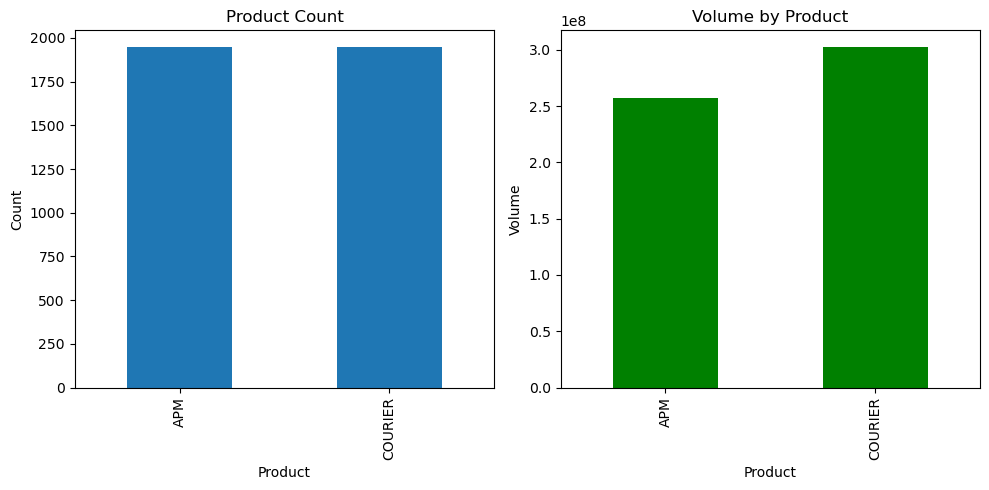

In [23]:
fig, sub = plt.subplots(1, 2, figsize=(10, 5))

df2.Product.value_counts().plot(kind='bar', ax = sub[0])
sub[0].set_title("Product Count")
sub[0].set_ylabel("Count")

df2.groupby("Product").Volume.sum().plot(kind='bar', ax = sub[1], color = "green")
sub[1].set_title("Volume by Product")
sub[1].set_ylabel("Volume")

plt.tight_layout()
plt.show()

The left plot shows the product count, which is fully balanced. However, the right plot indicates that the number of sent parcels is higher for couriers compared to APM.

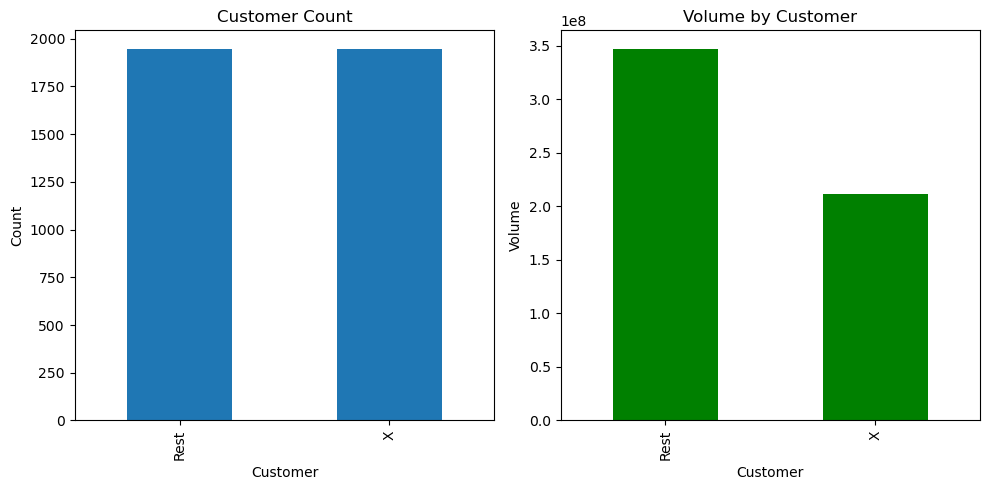

In [24]:
fig, sub = plt.subplots(1, 2, figsize=(10, 5))

df2.Customer.value_counts().plot(kind='bar', ax = sub[0])
sub[0].set_title("Customer Count")
sub[0].set_ylabel("Count")

df2.groupby("Customer").Volume.sum().plot(kind='bar', ax = sub[1], color = "green")
sub[1].set_title("Volume by Customer")
sub[1].set_ylabel("Volume")

plt.tight_layout()
plt.show()

Similar to the previous observation, the `Customer` column is also balanced. However, the other clients have higher parcel volumes compared to the single X client.

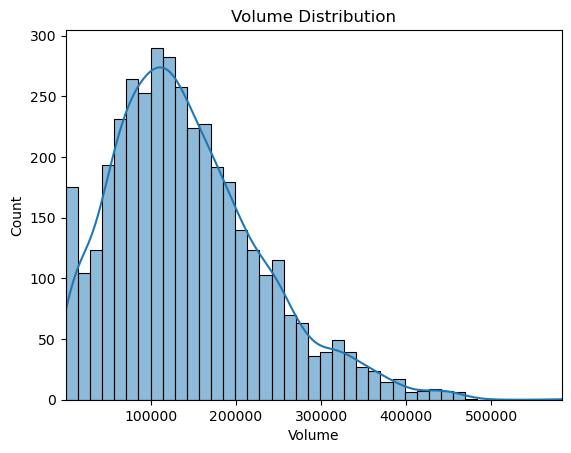

In [25]:
sns.histplot(df2.Volume, kde = True)
plt.xlim(df2.Volume.min(), df2.Volume.max())
plt.title('Volume Distribution')
plt.show()

The `Volume` variable has a right-skewed distribution, meaning most values are concentrated on the lower end, with fewer days having significantly higher parcel volumes.

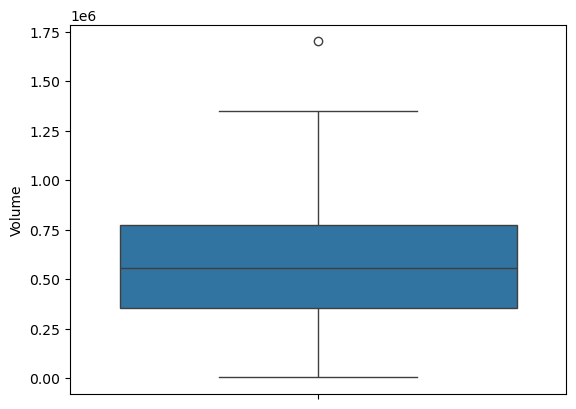

In [26]:
sns.boxplot(y = df2.Volume.groupby(df2.date).sum())
plt.show()

The boxplot reveals 1 outlier in the `Volume` variable, with a value exceeding 1,600,000 parcels per day.

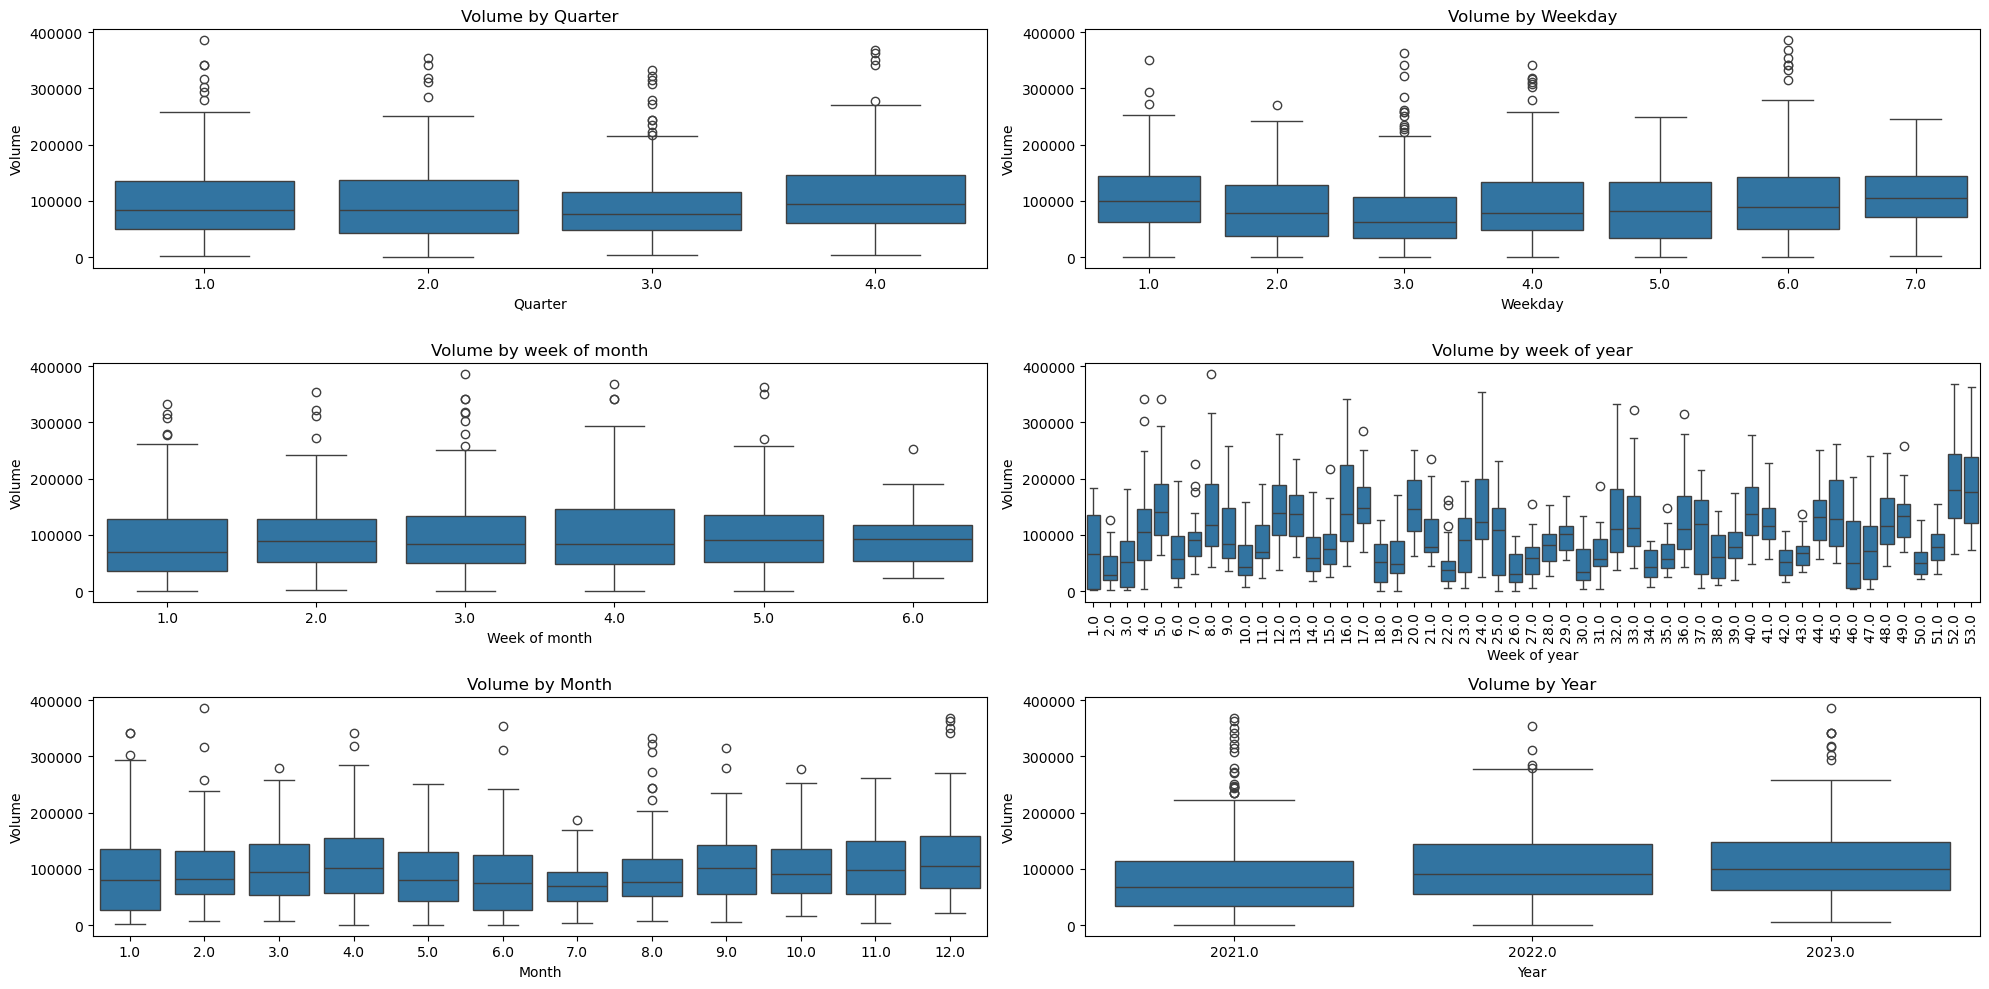

In [27]:
fig, sub = plt.subplots(3, 2, figsize=(20, 10))

sns.boxplot(x = df1["dateQuarter"], y = df2["Volume"], ax = sub[0, 0])
sub[0, 0].set_title("Volume by Quarter")
sub[0, 0].set_xlabel("Quarter")

sns.boxplot(x = df1["dateWeekDayStartsMonday"], y = df2["Volume"], ax = sub[0, 1])
sub[0, 1].set_title("Volume by Weekday")
sub[0, 1].set_xlabel("Weekday")

sns.boxplot(x = df1["dateWeekOfMonth"], y = df2["Volume"], ax = sub[1, 0])
sub[1, 0].set_title("Volume by week of month")
sub[1, 0].set_xlabel("Week of month")

sns.boxplot(x = df1["dateWeekOfYearStartsMonday"], y = df2["Volume"], ax = sub[1, 1])
sub[1, 1].set_xticklabels(sub[1, 1].get_xticklabels(), rotation=90)
sub[1, 1].set_title("Volume by week of year")
sub[1, 1].set_xlabel("Week of year")

sns.boxplot(x = df1["dateMonth"], y = df2["Volume"], ax = sub[2, 0])
sub[2, 0].set_title("Volume by Month")
sub[2, 0].set_xlabel("Month")

sns.boxplot(x = df1["dateYear"], y = df2["Volume"], ax = sub[2, 1])
sub[2, 1].set_title("Volume by Year")
sub[2, 1].set_xlabel("Year")

plt.tight_layout()
plt.show()

The plots above show how `Volume` depends on different time periods. As observed, the highest variability occurs during the week of the year, while other periods exhibit medium or low variability.

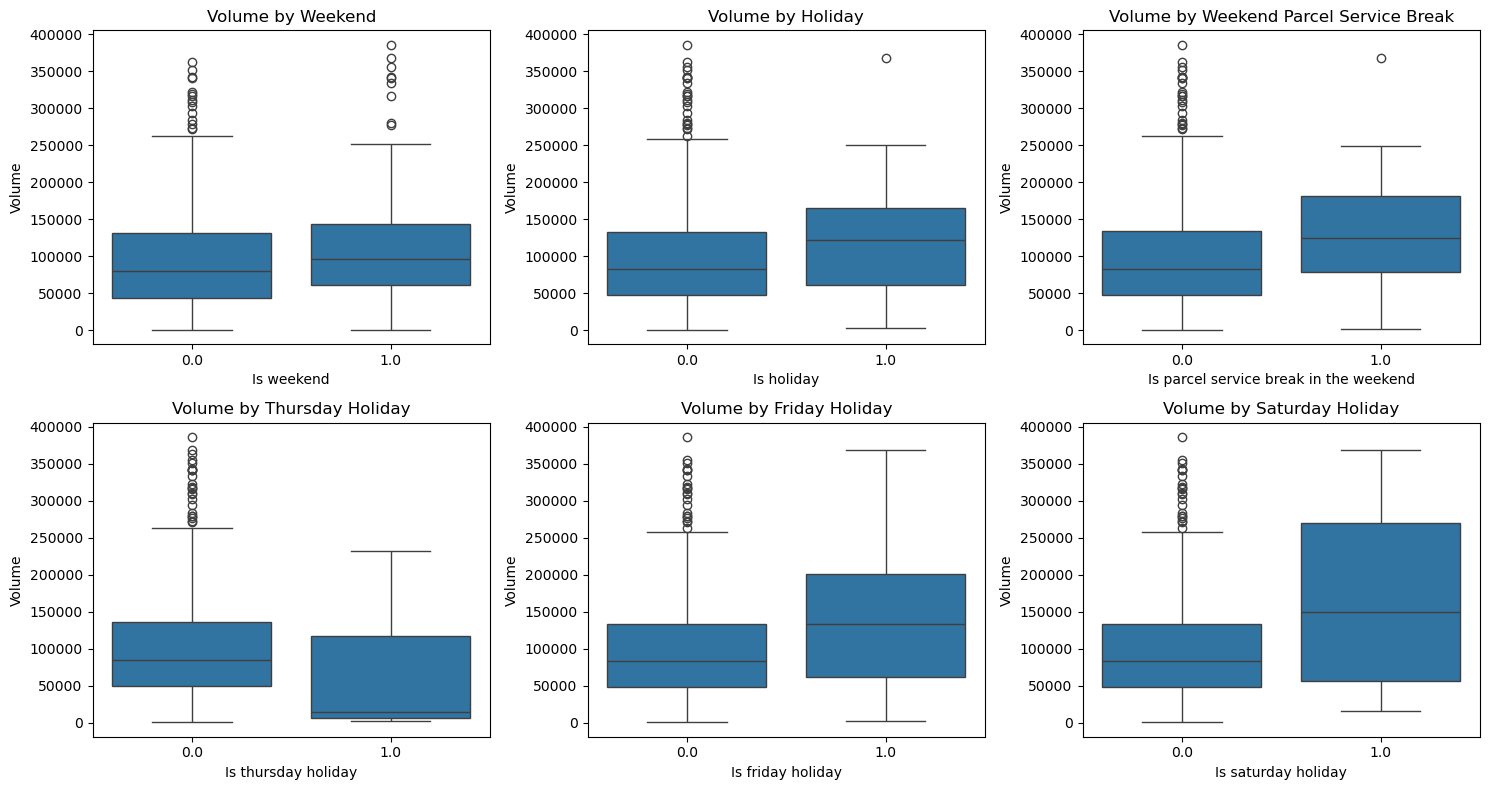

In [28]:
fig, sub = plt.subplots(2, 3, figsize=(15, 8))

sns.boxplot(x = df1["dateIsWeekend"], y = df2["Volume"], ax = sub[0, 0])
sub[0, 0].set_title("Volume by Weekend")
sub[0, 0].set_xlabel("Is weekend")

sns.boxplot(x = df1["dateIsHolidayInd"], y = df2["Volume"], ax = sub[0, 1])
sub[0, 1].set_title("Volume by Holiday")
sub[0, 1].set_xlabel("Is holiday")

sns.boxplot(x = df1["isWeekendParcelServiceBreakInd"], y = df2["Volume"], ax = sub[0, 2])
sub[0, 2].set_title("Volume by Weekend Parcel Service Break")
sub[0, 2].set_xlabel("Is parcel service break in the weekend")

sns.boxplot(x = df1["isThuHolyday"], y = df2["Volume"], ax = sub[1, 0])
sub[1, 0].set_title("Volume by Thursday Holiday")
sub[1, 0].set_xlabel("Is thursday holiday")

sns.boxplot(x = df1["isFriHolyday"], y = df2["Volume"], ax = sub[1, 1])
sub[1, 1].set_title("Volume by Friday Holiday")
sub[1, 1].set_xlabel("Is friday holiday")

sns.boxplot(x = df1["isSatHolyday"], y = df2["Volume"], ax = sub[1, 2])
sub[1, 2].set_title("Volume by Saturday Holiday")
sub[1, 2].set_xlabel("Is saturday holiday")

plt.tight_layout()
plt.show()

The plots show how `Volume` differs for boolean variables. The most significant difference is observed for the `isThuholiday` variable, where parcel volume is nearly where Thursday is holiday. 

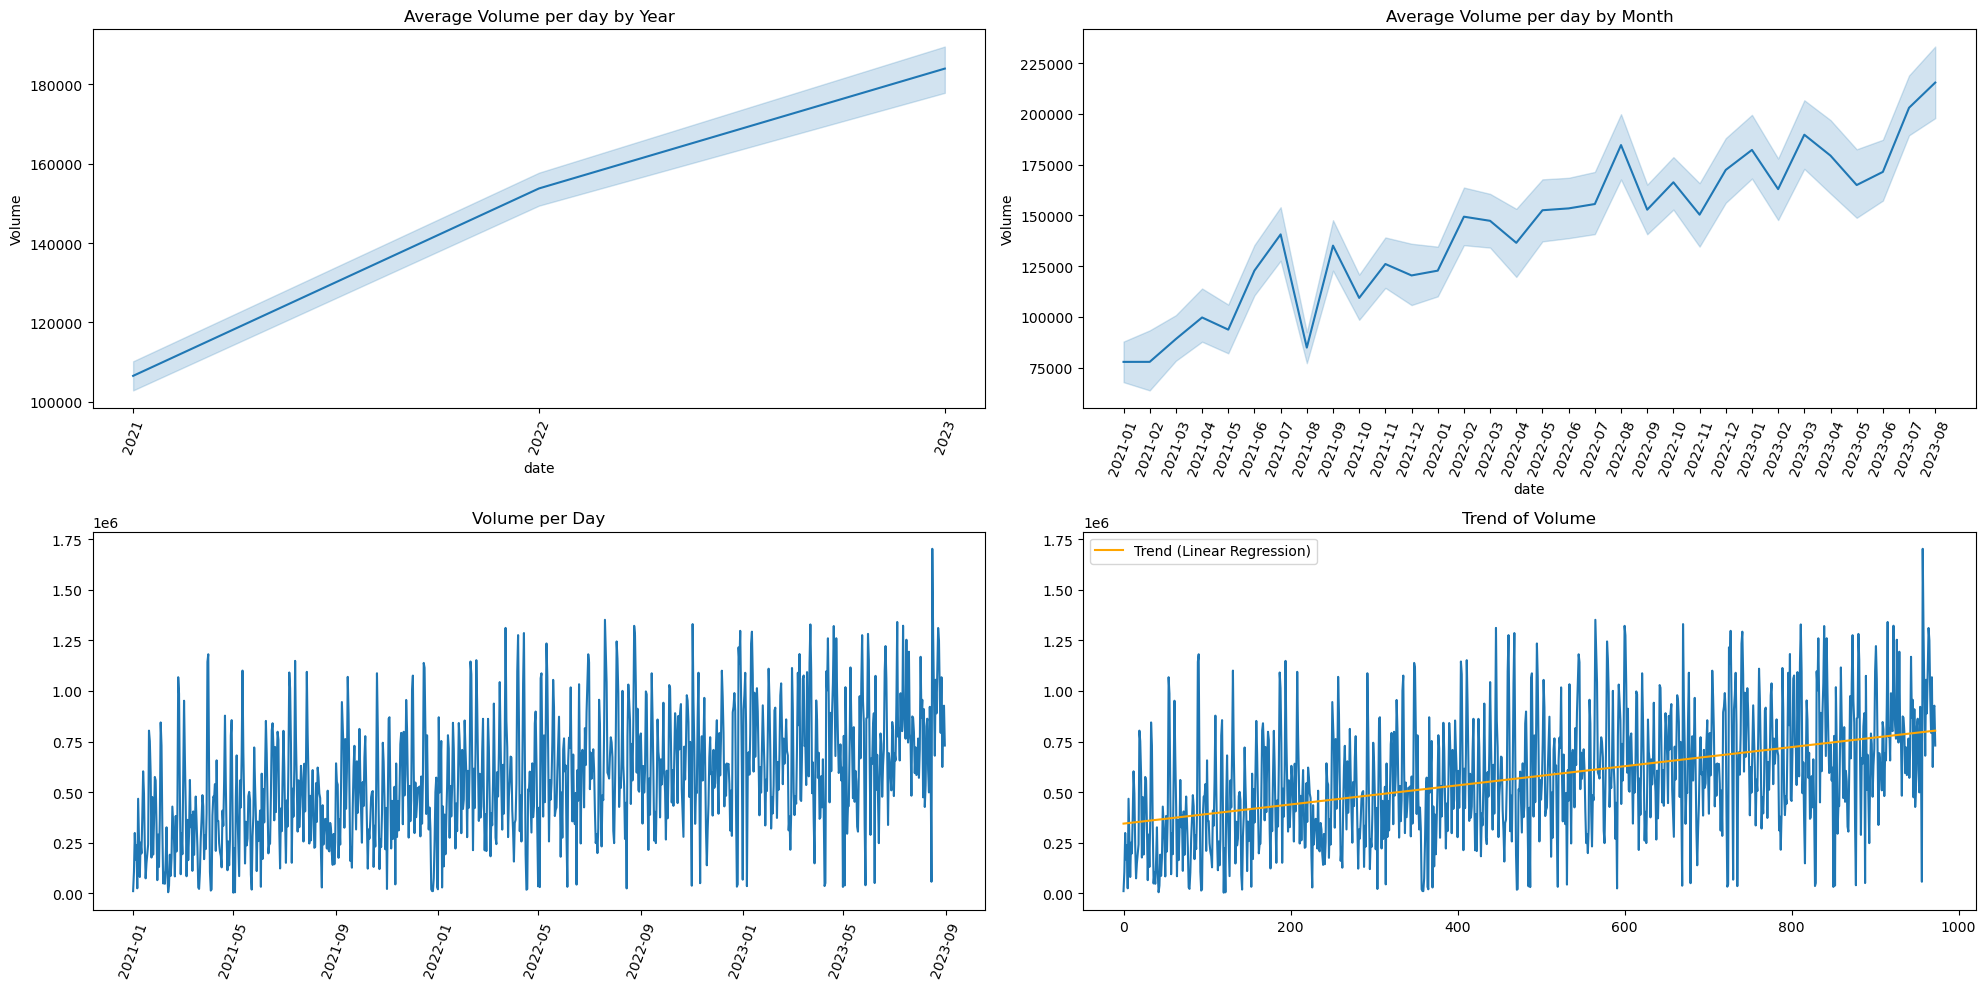

In [29]:
year = df2['date'].dt.to_period('Y').astype(str)
year_month = df2['date'].dt.to_period('M').astype(str)

fig, sub = plt.subplots(2, 2, figsize=(20, 10))

sns.lineplot(ax=sub[0, 0], x=year, y=df2['Volume'])
sub[0, 0].set_title("Average Volume per day by Year")
sub[0, 0].tick_params(axis='x', rotation=70)

sns.lineplot(ax=sub[0, 1], x=year_month, y=df2['Volume'])
sub[0, 1].set_title("Average Volume per day by Month")
sub[0, 1].tick_params(axis='x', rotation=70)

sns.lineplot(ax=sub[1, 0],x=df2["date"].unique(), y=list(df2.groupby("date").Volume.sum()))
sub[1, 0].set_title("Volume per Day")
sub[1, 0].tick_params(axis='x', rotation=70)

time = np.arange(len(list(df2.groupby("date").Volume.sum()))) 
model = LinearRegression()
model.fit(time.reshape(-1, 1), list(df2.groupby("date").Volume.sum()))
trend = model.predict(time.reshape(-1, 1))

sns.lineplot(ax = sub[1, 1], x = time, y = list(df2.groupby("date").Volume.sum()))
sns.lineplot(ax = sub[1, 1], x = time, y = trend, label="Trend (Linear Regression)", color='orange')
sub[1, 1].set_title("Trend of Volume")

plt.tight_layout()
plt.show()

The `Volume` shows a positive trend, indicating an increase over time. Additionally, in the plot with daily volumes, the previously identified outlier is visible, representing the number of parcels on August 16, 2023.

In [30]:
print("2023-08-15:", df2[df2["date"] == f"2023-08-15"].Volume.sum())
print("2023-08-16:", df2[df2["date"] == f"2023-08-16"].Volume.sum())
print("")
df1[(df1["date"] == "2023-08-15") | (df1["date"] == "2023-08-16")][["date", "dateIsHolidayInd"]]

2023-08-15: 57688
2023-08-16: 1701724



,date,dateIsHolidayInd
956,2023-08-15,1
957,2023-08-16,0


On the previous day, August 15, the number of parcels was significantly lower (57k compared to 1.7m). Additionally, August 15, 2023, was a holiday in Poland, which logically explains the smaller parcel volume. On the following day, August 16, there was an attempt to catch up, resulting in the higher parcel volume.

In [31]:
print("2022-11-11:", df2[df2["date"] == f"2022-11-11"].Volume.sum())
print("2022-11-12:", df2[df2["date"] == f"2022-11-12"].Volume.sum())
print("")
df1[(df1["date"] == "2022-11-11") | (df1["date"] == "2022-11-12")][["date", "dateIsHolidayInd"]]

2022-11-11: 50544
2022-11-12: 649317



,date,dateIsHolidayInd
679,2022-11-11,1
680,2022-11-12,0


The same pattern is observed on November 11, 2023, which is Independence Day in Poland. The parcel volume on November 11 is lower due to the holiday, and the following day shows a spike as the parcels are likely oversent to catch up.

In [32]:
df2_X = df2[df2["Customer"] == "X"].groupby("date").Volume.sum()
df2 = df2.groupby(["date"])["Volume"].sum().reset_index()

I grouped the parcel `Volume` by day, as the goal is to forecast daily volume regardless of the shipment type or customer. Additionally, I saved the volume data only for the X client to use it in future analyses.

In [33]:
df2

,date,Volume
0,2021-01-01,11366
1,2021-01-02,106466
2,2021-01-03,298551
3,2021-01-04,167549
4,2021-01-05,237147
...,...,...
968,2023-08-27,1067478
969,2023-08-28,624374
970,2023-08-29,916677
971,2023-08-30,927150


## X_ClientORDERS - Data preprocessing

In [34]:
df3 = pd.read_excel("data/X_ClientORDERS.xlsx")
df3

,DateId,Orders
0,20230101,161366.064671
1,20230102,296627.324653
2,20230103,378262.368584
3,20230104,320907.583398
4,20230105,93098.214405
...,...,...
238,20230827,257302.285086
239,20230828,334471.057583
240,20230829,407334.926198
241,20230830,354357.441720


The table contains a prediction for the next day, but the last row does not have a prediction for September 1, 2023. Therefore, I will remove this row.

In [35]:
df3 = df3.drop(len(df3)-1, axis = 0)

In [36]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 242 entries, 0 to 241
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   DateId  242 non-null    int64  
 1   Orders  242 non-null    float64
dtypes: float64(1), int64(1)
memory usage: 3.9 KB


The column with the date is currently in integer format, so I will convert it to datetime. Similarly, I will convert the `Orders` column to integer, as the number of parcels cannot be a float.

In [37]:
df3.DateId = pd.to_datetime(df3.DateId, format='%Y%m%d')
df3 = df3.rename(columns = {"DateId": "date"})
df3.Orders = df3.Orders.astype(int)

In [38]:
df3.Orders.describe()

count       242.000000
mean     275093.876033
std       70057.787884
min       72473.000000
25%      224505.250000
50%      273695.500000
75%      325643.750000
max      416068.000000
Name: Orders, dtype: float64

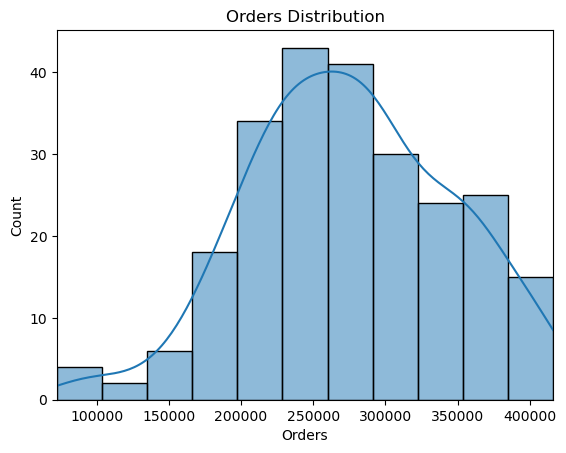

In [39]:
sns.histplot(df3.Orders, kde = True)
plt.xlim(df3.Orders.min(), df3.Orders.max())
plt.title('Orders Distribution')
plt.show()

The distribution of `Orders` is slightly skewed, but it is very close to a normal distribution.

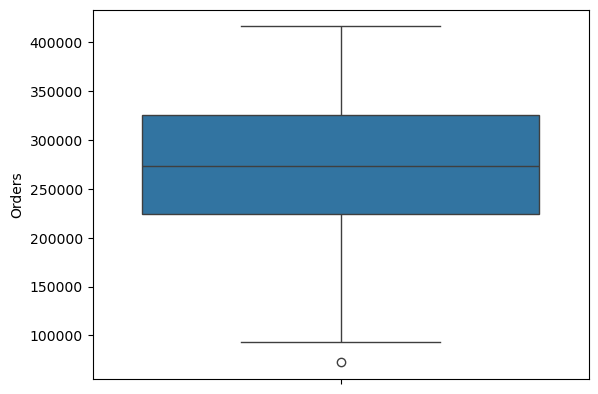

In [40]:
sns.boxplot(y = df3.Orders)
plt.show()

Boxplot indicates 1 outlier for value lower than 100,000.

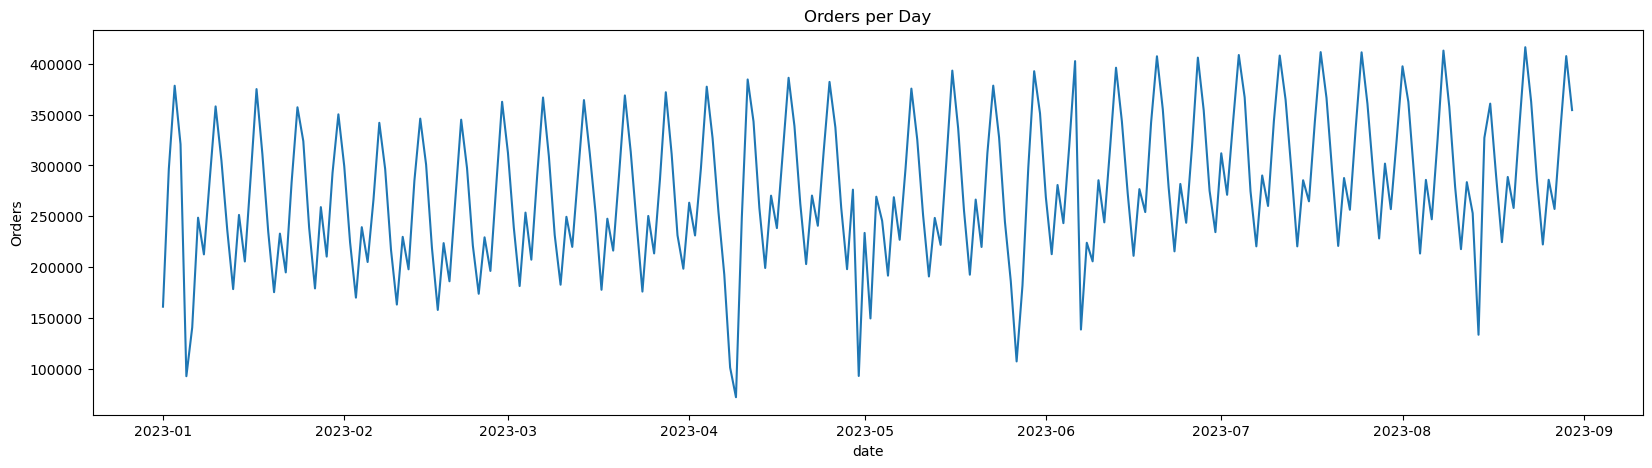

In [41]:
plt.figure(figsize=(20, 5))

sns.lineplot(x=df3.date, y=df3.Orders)
plt.title("Orders per Day")
plt.show()

The plot shows seasonality in the `Orders`, with a 7-day cycle, indicating weekly patterns in parcel volumes.

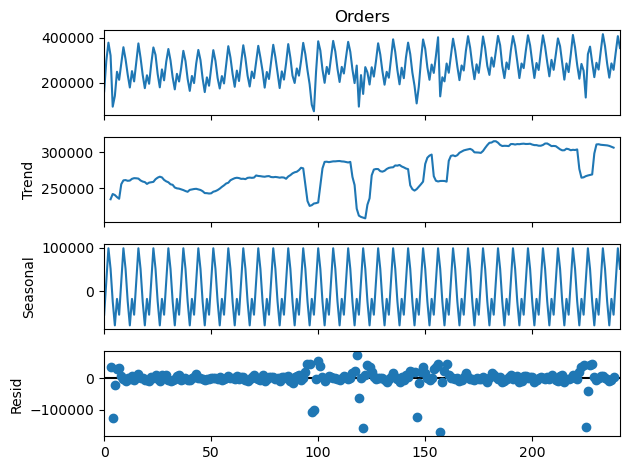

In [42]:
result = seasonal_decompose(df3['Orders'], model='additive', period=7)
result.plot()
plt.show()

The seasonal component obtained from the `seasonal_decompose()` function highlights the recurring fluctuations within the time series.

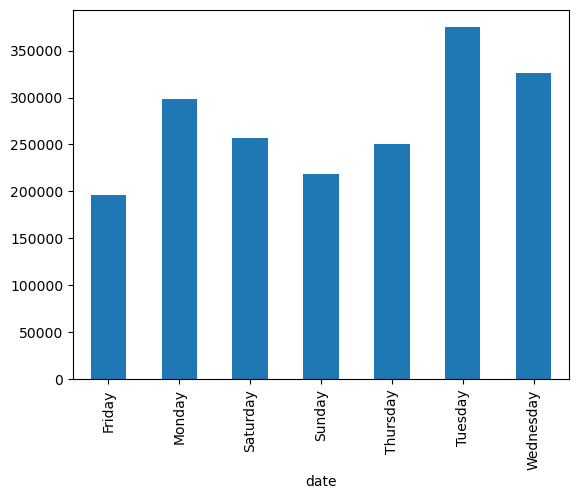

In [43]:
week_day = df3['date'].dt.day_name()
df3.groupby(week_day)['Orders'].mean().plot(kind='bar')
plt.show()

The predictions indicate that the highest volume is expected on Tuesday, while the lowest volume on Friday.

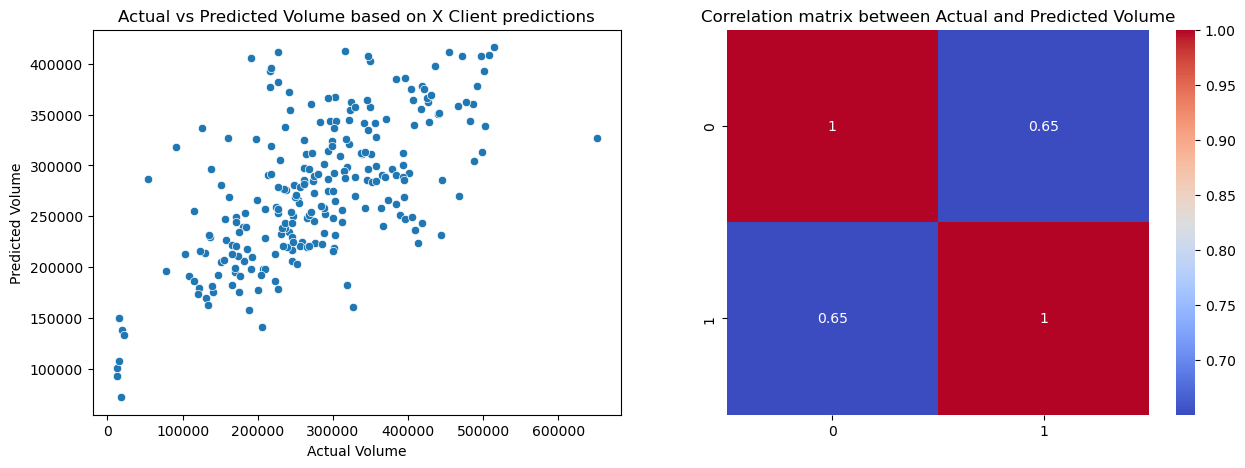

In [44]:
actual = list(df2_X[df2_X.index > "2023-01-01"].values)
predicted = df3.Orders

fig, sub = plt.subplots(1, 2, figsize=(15, 5))

sns.scatterplot(x = actual, y = predicted, ax = sub[0])
sub[0].set_xlabel("Actual Volume")
sub[0].set_ylabel("Predicted Volume")
sub[0].set_title("Actual vs Predicted Volume based on X Client predictions")

sns.heatmap(np.corrcoef(actual, predicted), annot = True, cmap = "coolwarm", ax = sub[1])
sub[1].set_title("Correlation matrix between Actual and Predicted Volume")
plt.show()

There is a moderate correlation between the actual shipments for Client X and the predicted values.
However, since predictions are only available from 01-01-2023 onward, this column will have missing values for earlier dates. On one hand, artificially filling these values could lead to data leakage or overly optimistic forecasting results. On the other hand, training the model using only data from January 1, 2023, onward would result in a significant loss of data. Therefore, I have decided not to include Client X forecasts as a predictor in my future models.

## Temperatures - Data preprocessing

There are individual CSV files for each month containing weather data. I will merge them into a single dataset using the `os` library.

In [45]:
csv_files = [file for file in os.listdir("data/Temp") if file.endswith('.csv')]
dataframes = []

for file in csv_files:
    file_path = os.path.join("data/Temp", file)
    dataframes.append(pd.read_csv(file_path))

df4 = pd.concat(dataframes, ignore_index=True)

df4

,Nazwa stacji,Rok,Miesiac,Dzien,Maksymalna temperatura dobowa,Minimalna temperatura dobowa,Srednia temperatura dobowa,Suma dobowa opadow [mm],Pokrywa sniegu [cm]
0,KRAKOW,2021,1,1,0.5,-1.2,-0.5,0.0,0
1,KRAKOW,2021,1,2,4.4,-1.6,0.8,0.0,0
2,KRAKOW,2021,1,3,4.0,-0.9,1.1,0.0,0
3,KRAKOW,2021,1,4,4.9,-0.7,1.7,7.1,0
4,KRAKOW,2021,1,5,3.7,1.4,2.5,4.3,0
...,...,...,...,...,...,...,...,...,...
1941,WARSZAWA,2022,12,27,8.9,2.6,4.6,0.0,0
1942,WARSZAWA,2022,12,28,4.9,-0.2,2.5,0.0,0
1943,WARSZAWA,2022,12,29,8.3,3.3,5.8,0.0,0
1944,WARSZAWA,2022,12,30,8.7,4.0,5.9,0.0,0


In [46]:
df4 = df4.rename(columns = {"Nazwa stacji": "city",
                            "Rok": "year",
                            "Miesiac": "month",
                            "Dzien": "day",
                            "Maksymalna temperatura dobowa": "temp_max", 
                            "Minimalna temperatura dobowa": "temp_min",
                            "Srednia temperatura dobowa": "temp_avg",
                            "Suma dobowa opadow [mm]": "total_rainfall",
                            "Pokrywa sniegu [cm]": "snow_cover",
                            })

df4['date'] = pd.to_datetime(df4[['year', 'month', 'day']])
df4 = df4.drop(["year", "month", "day"], axis = 1)
df4 = df4.sort_values(by = "date").reset_index(drop = True)

I renamed the columns and combined the `year`, `month`, and `day` columns into a single `datetime` column.

In [47]:
df4 = df4[["date", "city", "temp_max", "temp_min", "temp_avg", "total_rainfall", "snow_cover"]]
df4.head()

,date,city,temp_max,temp_min,temp_avg,total_rainfall,snow_cover
0,2021-01-01,KRAKOW,0.5,-1.2,-0.5,0.0,0
1,2021-01-01,WARSZAWA,0.9,-1.2,-0.2,0.0,0
2,2021-01-02,KRAKOW,4.4,-1.6,0.8,0.0,0
3,2021-01-02,WARSZAWA,1.2,-0.9,0.3,0.0,0
4,2021-01-03,KRAKOW,4.0,-0.9,1.1,0.0,0


Unfortunately, the dataset contains weather data from only two stations in Poland: Kraków and Warszawa, and the forecasting task will not focus on city-level volumes. Therefore, despite estimating countrywide temperatures based on just these two cities, I will aggregate the data by date, as this is the only available data for my task.

In [48]:
temp_max = df4.groupby("date").temp_max.max().values
temp_min = df4.groupby("date").temp_min.min().values
temp_avg = df4.groupby("date").temp_avg.mean().values
total_rainfall = df4.groupby("date").total_rainfall.sum().values
snow_cover = df4.groupby("date").snow_cover.max().values

df4 = pd.DataFrame({"date": df4.date.unique(), 
                    "temp_max": temp_max, 
                    "temp_min": temp_min, 
                    "temp_avg": temp_avg, 
                    "total_rainfall": total_rainfall, 
                    "snow_cover": snow_cover})

In [49]:
df4

,date,temp_max,temp_min,temp_avg,total_rainfall,snow_cover
0,2021-01-01,0.9,-1.2,-0.35,0.0,0
1,2021-01-02,4.4,-1.6,0.55,0.0,0
2,2021-01-03,4.0,-0.9,1.15,0.0,0
3,2021-01-04,4.9,-0.7,1.95,7.1,0
4,2021-01-05,4.0,1.4,2.65,4.3,0
...,...,...,...,...,...,...
968,2023-08-27,28.6,17.7,22.20,0.5,0
969,2023-08-28,23.7,17.3,19.45,0.1,0
970,2023-08-29,26.1,17.5,21.05,0.9,0
971,2023-08-30,22.0,16.7,18.30,0.3,0


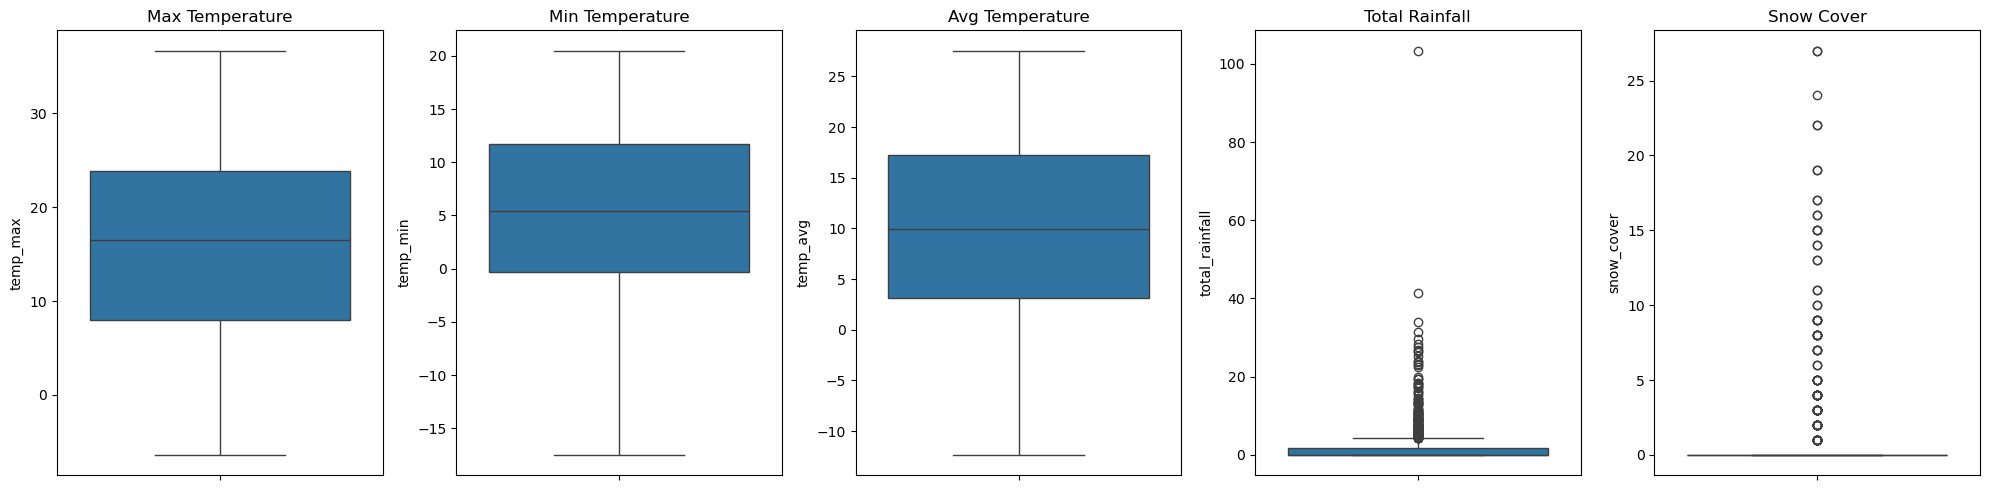

In [50]:
fig, sub = plt.subplots(1, 5, figsize=(20, 5))

sns.boxplot(y = df4.temp_max, ax = sub[0])
sub[0].set_title("Max Temperature")

sns.boxplot(y = df4.temp_min, ax = sub[1])
sub[1].set_title("Min Temperature")

sns.boxplot(y = df4.temp_avg, ax = sub[2])
sub[2].set_title("Avg Temperature")


sns.boxplot(y = df4.total_rainfall, ax = sub[3])
sub[3].set_title("Total Rainfall")

sns.boxplot(y = df4.snow_cover, ax = sub[4])
sub[4].set_title("Snow Cover")

plt.tight_layout()
plt.show()


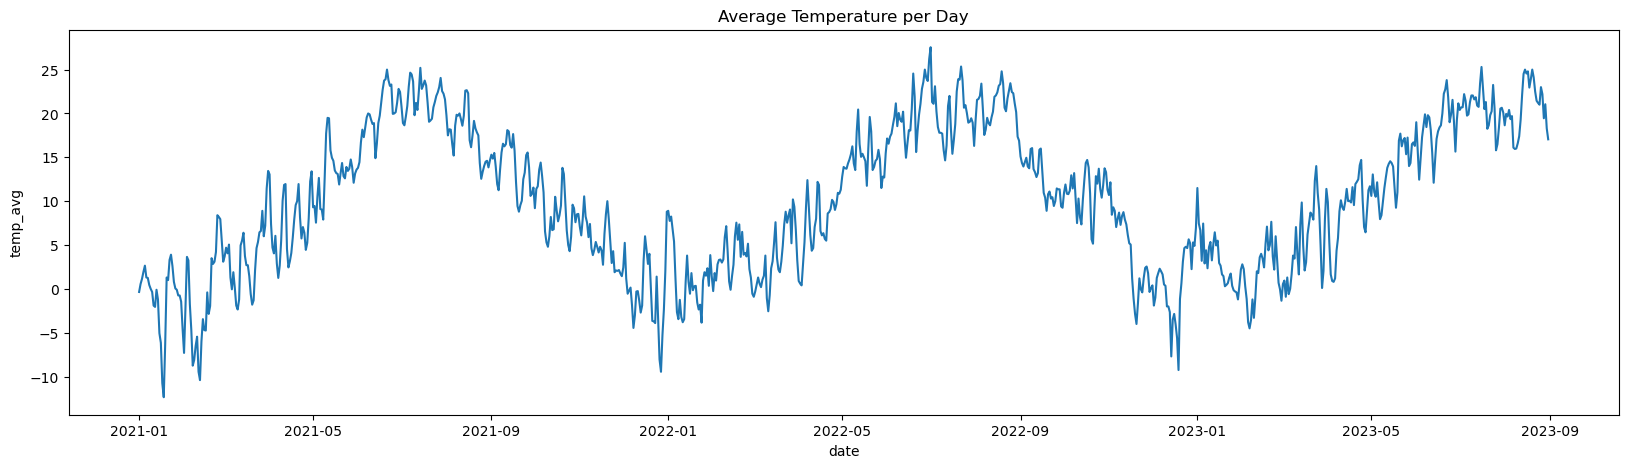

In [51]:
plt.figure(figsize=(20, 5))
sns.lineplot(x=df4.date, y=df4.temp_avg)
plt.title("Average Temperature per Day")
plt.show()

There is a clear yearly seasonal pattern in the temperature data, which is logically expected.

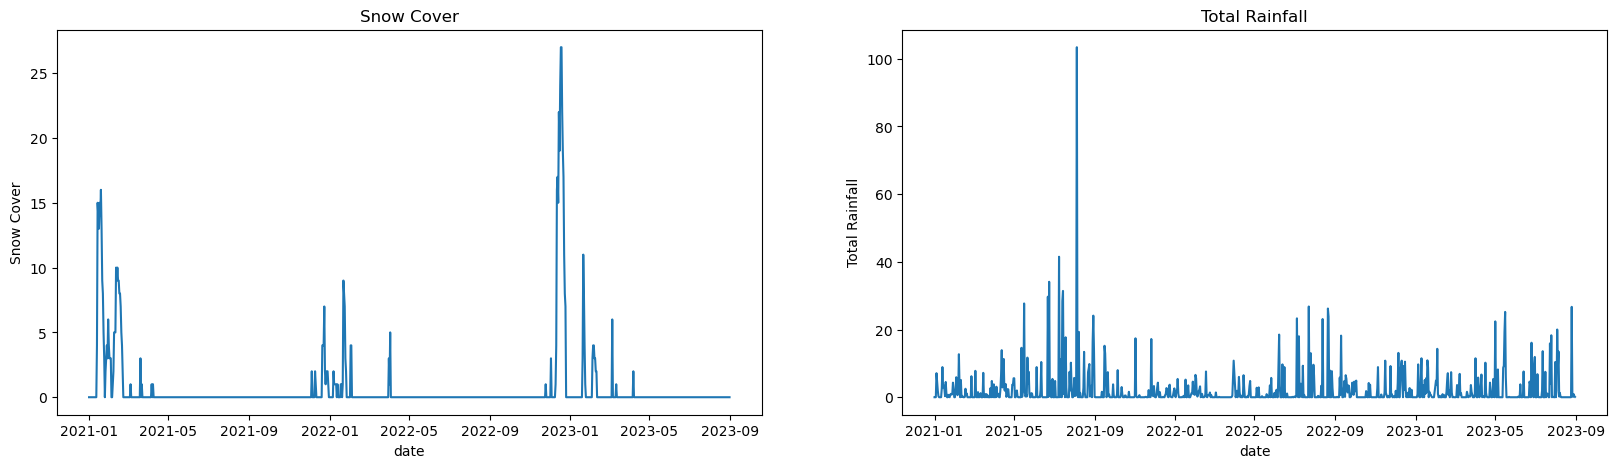

In [52]:
fig, sub = plt.subplots(1, 2, figsize=(20, 5))


sns.lineplot(x=df4.date, y=df4.snow_cover, ax = sub[0])
sub[0].set_title("Snow Cover")
sub[0].set_ylabel("Snow Cover")

sns.lineplot(x=df4.date, y=df4.total_rainfall)
sub[1].set_title("Total Rainfall")
sub[1].set_ylabel("Total Rainfall")

plt.show()

The plot on the right shows occurrences of snow in the spring, most likely in April. The highest rainfall was recorded in the summer of 2021.

## Data merging

In [53]:
df = df2.merge(df1, left_on="date", right_on = "date", how="left")
df = df.merge(df4, left_on="date", right_on = "date", how="left")

df.to_csv("data/merged_data.csv", index=False)

df.index = df.date
df = df.drop("date", axis = 1)
df.sort_index(inplace=True)

I merged all datasets using a left join and saved the result as a CSV file. Additionally, for the final dataset, I set the date as the index and removed the date column.

In [54]:
df

,Volume,dateYear,dateMonth,dateDay,dateDayOfYear,dateWeekOfMonth,dateQuarter,dateIsWeekend,dateIsHolidayInd,dateWeekDayStartsMonday,...,firstDayNoSaturdayNoHolidayOrSundayHolidayIsHoliday,isThuHolyday,isFriHolyday,isSatHolyday,isWeekendParcelServiceBreakInd,temp_max,temp_min,temp_avg,total_rainfall,snow_cover
date,,,,,,,,,,,,,,,,,,,,,
2021-01-01,11366,2021,1,1,1,1,1,0,1,5,...,0,1,1,0,0,0.9,-1.2,-0.35,0.0,0
2021-01-02,106466,2021,1,2,2,1,1,1,0,6,...,0,1,1,0,1,4.4,-1.6,0.55,0.0,0
2021-01-03,298551,2021,1,3,3,2,1,1,0,7,...,0,0,0,0,0,4.0,-0.9,1.15,0.0,0
2021-01-04,167549,2021,1,4,4,2,1,0,0,1,...,0,0,0,0,0,4.9,-0.7,1.95,7.1,0
2021-01-05,237147,2021,1,5,5,2,1,0,0,2,...,0,0,0,0,0,4.0,1.4,2.65,4.3,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-08-27,1067478,2023,8,27,239,5,3,1,0,7,...,0,0,0,0,0,28.6,17.7,22.20,0.5,0
2023-08-28,624374,2023,8,28,240,5,3,0,0,1,...,0,0,0,0,0,23.7,17.3,19.45,0.1,0
2023-08-29,916677,2023,8,29,241,5,3,0,0,2,...,0,0,0,0,0,26.1,17.5,21.05,0.9,0


In [55]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 973 entries, 2021-01-01 to 2023-08-31
Data columns (total 21 columns):
 #   Column                                               Non-Null Count  Dtype  
---  ------                                               --------------  -----  
 0   Volume                                               973 non-null    int32  
 1   dateYear                                             973 non-null    int64  
 2   dateMonth                                            973 non-null    int64  
 3   dateDay                                              973 non-null    int64  
 4   dateDayOfYear                                        973 non-null    int64  
 5   dateWeekOfMonth                                      973 non-null    int64  
 6   dateQuarter                                          973 non-null    int64  
 7   dateIsWeekend                                        973 non-null    int64  
 8   dateIsHolidayInd                                   

In [56]:
IQR = df.Volume.quantile(0.75) - df.Volume.quantile(0.25)
lower_bound = df.Volume.quantile(0.25) - 1.5*IQR
upper_bound = df.Volume.quantile(0.75) + 1.5*IQR

df[(df.Volume <= lower_bound) | (df.Volume >= upper_bound)]

,Volume,dateYear,dateMonth,dateDay,dateDayOfYear,dateWeekOfMonth,dateQuarter,dateIsWeekend,dateIsHolidayInd,dateWeekDayStartsMonday,...,firstDayNoSaturdayNoHolidayOrSundayHolidayIsHoliday,isThuHolyday,isFriHolyday,isSatHolyday,isWeekendParcelServiceBreakInd,temp_max,temp_min,temp_avg,total_rainfall,snow_cover
date,,,,,,,,,,,,,,,,,,,,,
2023-08-16,1701724,2023,8,16,228,3,3,0,0,3,...,0,0,0,0,0,32.5,17.2,24.55,0.0,0


The IQR method identifies the value of 1.7m as an outlier. To mitigate its impact on the target variable, I will slightly adjust this value using interpolation.

In [57]:
df.loc[df.Volume == 1701724, "Volume"] = np.nan
df = df.interpolate(method='linear', limit_direction='forward')
df.loc["2023-08-16", "Volume"]

668926.0

The value was reduced from 1.7m to 669k, while preserving the pattern of a significant spike in parcel volume on the day following a holiday.

## SARIMA model

SARIMA (Seasonal Auto-Regressive Integrated Moving Average) is an extension of the ARIMA model that incorporates seasonality in addition to the non-seasonal components.

In [58]:
df_arima = df.Volume

I will split the dataset into training and testing sets, allocating 90 observations for testing and the remaining data for training the model.

In [59]:
test_days = 90
train = df_arima[:-test_days]
test = df_arima[-test_days:]
len(train), len(test)

(883, 90)

I am using the Augmented Dickey-Fuller (ADF) test to assess the stationarity of the time series. The null hypothesis ($H_0$) states that the time series is not stationary, while the alternative hypothesis ($H_1$) indicates that the time series is stationary.

In [60]:
result = adfuller(train)
print("p-value:", result[1])

p-value: 0.030583610660128577


The p-value is 0.03, which is less than the significance level of 0.05. Therefore, I reject the null hypothesis, concluding that the time series is stationary.

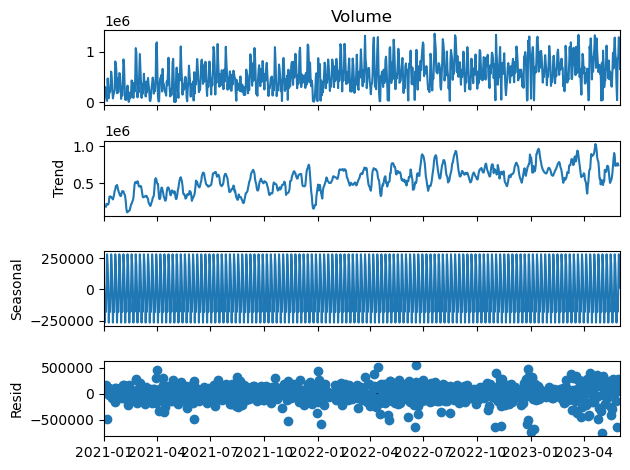

In [61]:
weekly_decompose = seasonal_decompose(train, model="additive", period=7)
weekly_decompose.plot()

plt.show()

The seasonal_decompose plot reveals a weekly pattern in the seasonal component, leading to the selection of the SARIMA model for forecasting.

I will use the `auto_arima` function to determine the optimal parameters for the model.

In [62]:
model_auto = auto_arima(train, seasonal=True, m=7)
print(f"Suggested ARIMA parameters: {model_auto.order}x{model_auto.seasonal_order}")

Suggested ARIMA parameters: (4, 1, 2)x(2, 0, 1, 7)


In [63]:
p, d, q = model_auto.order
P, D, Q, S = model_auto.seasonal_order
arima = ARIMA(train, order=(p,d,q), seasonal_order=(P,D,Q,S)).fit()
print(arima.summary())

                                     SARIMAX Results                                     
Dep. Variable:                            Volume   No. Observations:                  883
Model:             ARIMA(4, 1, 2)x(2, 0, [1], 7)   Log Likelihood              -11985.064
Date:                           Sat, 05 Apr 2025   AIC                          23990.128
Time:                                   16:40:58   BIC                          24037.949
Sample:                               01-01-2021   HQIC                         24008.414
                                    - 06-02-2023                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5036      0.037    -13.578      0.000      -0.576      -0.431
ar.L2          0.4782      0.046     10.468

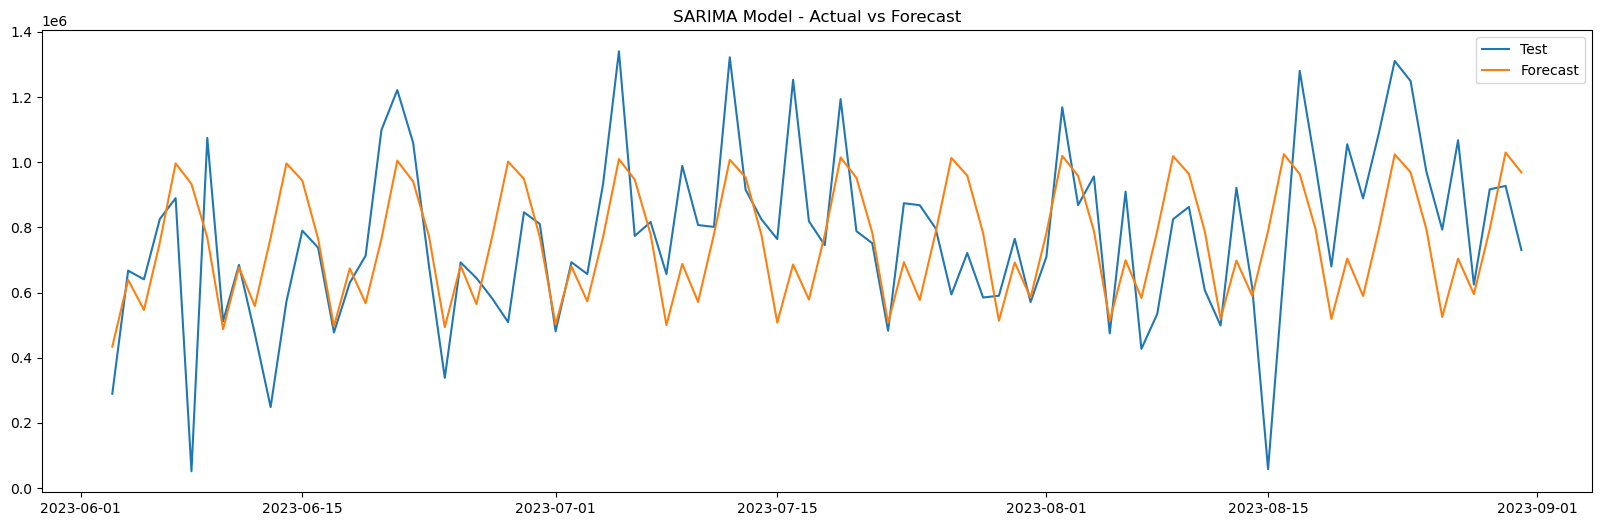

RMSE: 240707.6392
MAE: 181160.8628


In [64]:
forecast = arima.forecast(steps=len(test))

rmse_sarima = np.sqrt(mean_squared_error(test.values, forecast))
mae_sarima = mean_absolute_error(test.values, forecast)

plt.figure(figsize=(20, 6))
plt.plot(test, label='Test')
plt.plot(forecast, label='Forecast')
plt.legend(loc='best')
plt.title('SARIMA Model - Actual vs Forecast')
plt.show()

print(f"RMSE: {rmse_sarima:.4f}")
print(f"MAE: {mae_sarima:.4f}")

The SARIMA model's forecasts on the raw data are not highly accurate. Both RMSE and MAE values are large, and the plot comparing actual and predicted values indicates poor prediction performance.

### SARIMA Residual Analysis

In [65]:
residuals = arima.resid
stat, p = shapiro(residuals)
print('Statistics=%.3f, p=%.3f' % (stat, p))

Statistics=0.955, p=0.000


The p-value for the Shapiro-Wilk normality test is lower than 0.05, so I rejected $H_0$ regarding the normality of ARIMA's residuals.

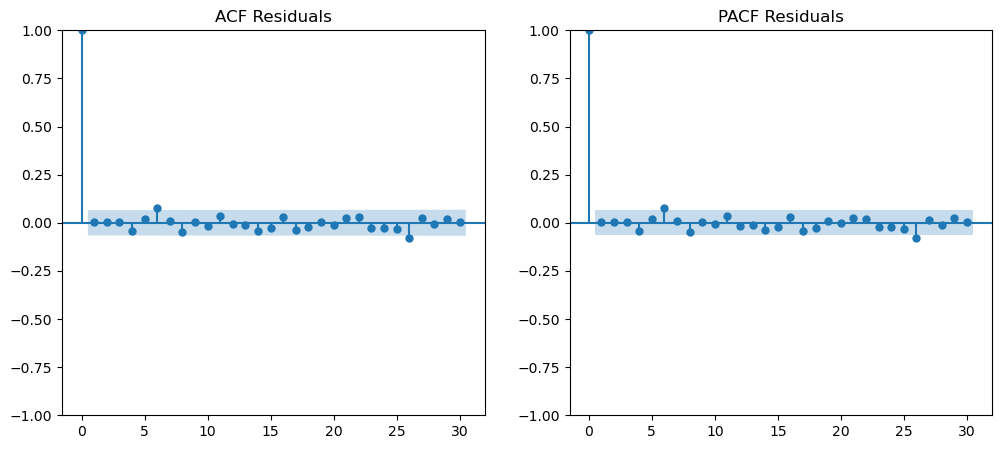

In [66]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

sm_api.graphics.tsa.plot_acf(residuals, lags=30, ax=ax[0])
ax[0].set_title("ACF Residuals")

sm_api.graphics.tsa.plot_pacf(residuals, lags=30, ax=ax[1])
ax[1].set_title("PACF Residuals")

plt.show()

Both ACF and PACF plots suggest that the residuals are random and show no autocorrelation. I will try a Box-Cox transformation to make the residuals follow a normal distribution.

### Box-Cox Transformation

In [67]:
train_transformed, lambda_bc = boxcox(train)
train_transformed = pd.Series(train_transformed, index=train.index)

model_auto = auto_arima(train_transformed, seasonal=True, m=7)

p, d, q = model_auto.order
P, D, Q, S = model_auto.seasonal_order

arima_tf = ARIMA(train_transformed, order=(p,d,q), seasonal_order=(P,D,Q,S)).fit()
print(arima_tf.summary())

                                     SARIMAX Results                                     
Dep. Variable:                                 y   No. Observations:                  883
Model:             ARIMA(1, 1, 0)x(2, 0, [1], 7)   Log Likelihood               -8541.801
Date:                           Sat, 05 Apr 2025   AIC                          17093.602
Time:                                   16:41:21   BIC                          17117.513
Sample:                               01-01-2021   HQIC                         17102.745
                                    - 06-02-2023                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2906      0.019    -15.076      0.000      -0.328      -0.253
ar.S.L7        0.9921      0.033     30.519

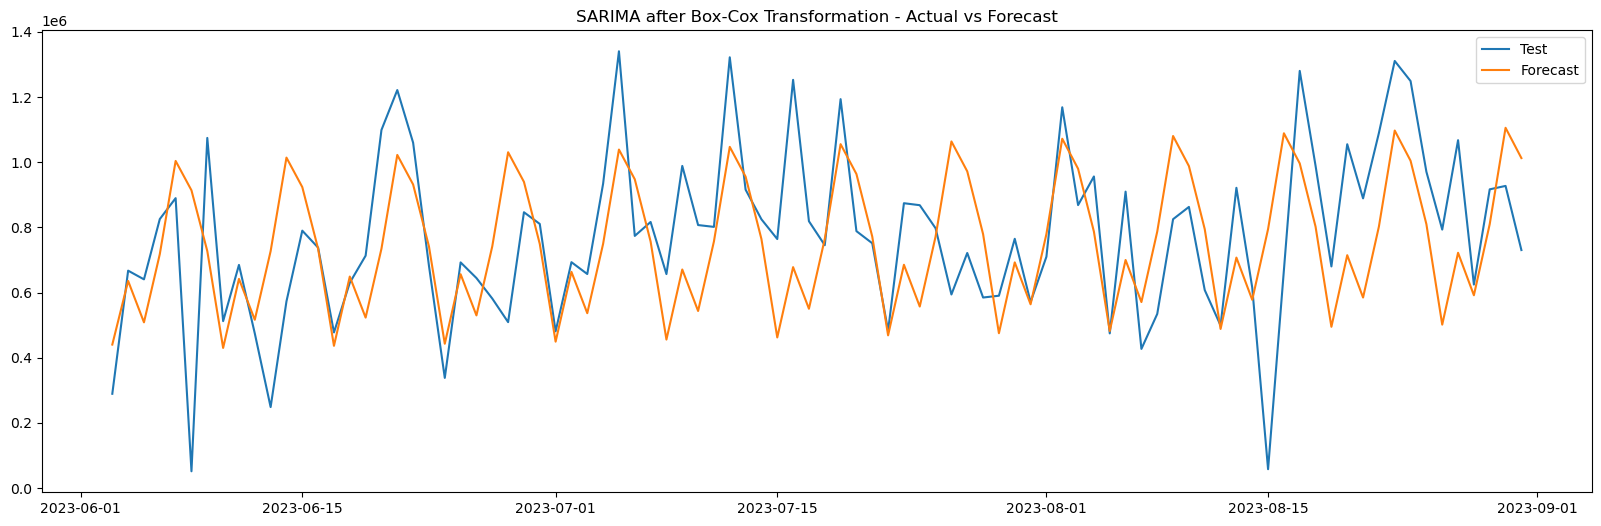

RMSE: 244996.2861
MAE: 186739.6402


In [68]:
forecast = arima_tf.forecast(steps=len(test))
forecast = inv_boxcox(forecast, lambda_bc)

rmse_sarima_tf = np.sqrt(mean_squared_error(test.values, forecast))
mae_sarima_tf = mean_absolute_error(test.values, forecast)

plt.figure(figsize=(20, 6))
plt.plot(test, label='Test')
plt.plot(forecast, label='Forecast')
plt.legend(loc='best')
plt.title('SARIMA after Box-Cox Transformation - Actual vs Forecast')
plt.show()

print(f"RMSE: {rmse_sarima_tf:.4f}")
print(f"MAE: {mae_sarima_tf:.4f}")

The SARIMA predictions after the Box-Cox transformation are worse than those on the raw data. Additionally, the metrics indicate that the SARIMA model cannot accurately predict this data—it is too complex for this model. Therefore, I will try other models.

## Prophet model

Prophet is a forecasting model developed by Facebook that handles time series data with strong seasonal patterns. It decomposes the data into trend, seasonality, and holidays, automatically detecting seasonal patterns and incorporating user-defined holidays.

In [69]:
ds = pd.to_datetime(df.index)
df_prophet = pd.DataFrame({"ds": ds, "y": df.Volume})
df_prophet.reset_index(drop=True, inplace=True)
df_prophet.head()

,ds,y
0,2021-01-01,11366.0
1,2021-01-02,106466.0
2,2021-01-03,298551.0
3,2021-01-04,167549.0
4,2021-01-05,237147.0


I transformed the data into the appropriate format for the Prophet model.

In [70]:
test_days = 90
train = df_prophet[:-test_days]
test = df_prophet[-test_days:]

len(train), len(test)

(883, 90)

Train/test split the same as before (883/90 days).

In [208]:
model = Prophet(seasonality_mode='additive')
model.add_seasonality(name='weekly', period=7, fourier_order=3)
model.fit(train)

I built a Prophet model with weekly seasonality and Fourier order equals 3

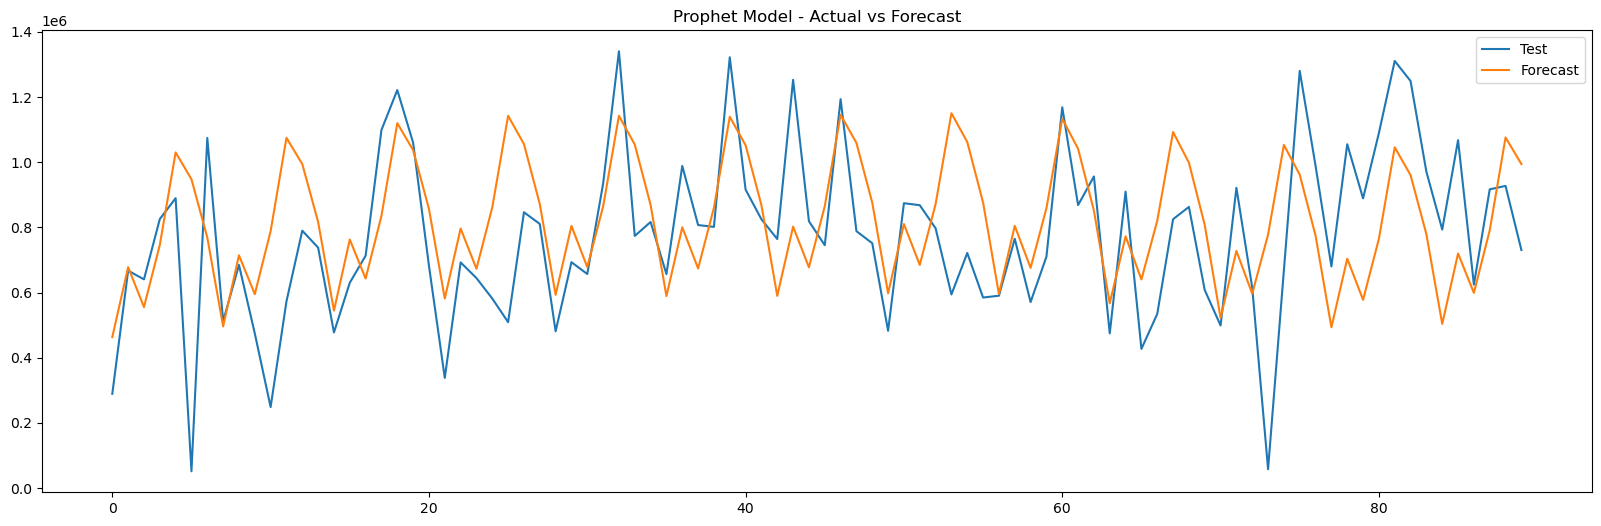

RMSE: 248832.0432
MAE: 190226.5271


In [209]:
future = model.make_future_dataframe(periods=len(test))
forecast = model.predict(future)
forecast_test = forecast[forecast['ds'].isin(test['ds'])]

y_true = test['y'].values
y_pred = forecast_test['yhat'].values

mae_prophet = mean_absolute_error(y_true, y_pred)
rmse_prophet = np.sqrt(mean_squared_error(y_true, y_pred))

plt.figure(figsize=(20, 6))
plt.plot(y_true, label='Test')
plt.plot(y_pred, label='Forecast')
plt.legend(loc='best')
plt.title('Prophet Model - Actual vs Forecast')
plt.show()

print(f"RMSE: {rmse_prophet:.4f}")
print(f"MAE: {mae_prophet:.4f}")

Similar to the SARIMA model, the Prophet model also shows low performance, with predictions deviating significantly from the actual values. I will try to tune hyperparameters of the Prophet model to improve performance

In [210]:
param_grid = {
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],
    'seasonality_mode': ['additive', 'multiplicative'],
    'fourier_order': [3, 5, 10]
}

param_combinations = list(itertools.product(
    param_grid['changepoint_prior_scale'], 
    param_grid['seasonality_prior_scale'], 
    param_grid['seasonality_mode'], 
    param_grid['fourier_order']
))

for cps, sps, sm, fo in param_combinations:
    model = Prophet(
        seasonality_mode=sm,
        changepoint_prior_scale=cps,
        seasonality_prior_scale=sps
    )
    
    model.add_seasonality(name='weekly', period=7, fourier_order=fo)
    model.fit(train)
    
    future = model.make_future_dataframe(periods=len(test))
    forecast = model.predict(future)
    forecast_test = forecast[forecast['ds'].isin(test['ds'])]
    
    y_true = test['y'].values
    y_pred = forecast_test['yhat'].values
    
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    
    if rmse < rmse_prophet:
        rmse_prophet = rmse
        best_params = (cps, sps, sm, fo)

print(f"The best parameters: changepoint_prior_scale={best_params[0]}, "
      f"seasonality_prior_scale={best_params[1]}, "
      f"seasonality_mode={best_params[2]}, "
      f"fourier_order={best_params[3]}")

print(f"The best RMSE: {rmse_prophet:.4f}")

The best parameters: changepoint_prior_scale=0.1, seasonality_prior_scale=0.01, seasonality_mode=additive, fourier_order=5
The best RMSE: 231038.4230


After hyperparameter tuning, the RMSE decreased slightly, but it is still high, and the model has poor predictive performance. Therefore, I will try machine learning models, which should perform better for time series forecasting problems.

## ML / DL forecasting models

Machine learning models and neural networks often outperform traditional statistical algorithms, so I will train several tree-based models and neural networks for forecasting. LSTM networks are known to be highly effective for time series forecasting (despite the rise of transformers), but will it be the best choice for this project?

In [74]:
df.isna().sum().sum(), df.duplicated().sum()

(0, 0)

### Feature engineering

ML/DL models will be built for multivariate forecasting, so I need to prepare the predictors to achieve better models performance.

I will transform cyclic features into sin/cos representations to inform the model that Sunday and Monday are close to each other, despite their numerical distance (1 and 7). It's important to note that the day of the month is not a cyclic feature, as days vary across months and February has fewer days.

In [75]:
cyclic_features = ["dateMonth", "dateDayOfYear", "dateWeekOfMonth", "dateQuarter", "dateWeekDayStartsMonday", "dateWeekOfYearStartsMonday"]

def create_cyclic_features(df, column, period):
    df[column + '_sin'] = np.sin(2 * np.pi * df[column] / period)
    df[column + '_cos'] = np.cos(2 * np.pi * df[column] / period)
    df = df.drop(column, axis=1)
    return df

for col in cyclic_features:
    df = create_cyclic_features(df, col, df[col].nunique())


df.iloc[:10, -10:]

,dateDayOfYear_sin,dateDayOfYear_cos,dateWeekOfMonth_sin,dateWeekOfMonth_cos,dateQuarter_sin,dateQuarter_cos,dateWeekDayStartsMonday_sin,dateWeekDayStartsMonday_cos,dateWeekOfYearStartsMonday_sin,dateWeekOfYearStartsMonday_cos
date,,,,,,,,,,
2021-01-01,0.017213,0.999852,8.660254e-01,0.5,1.0,6.123234e-17,-9.749279e-01,-0.222521,0.118273,0.992981
2021-01-02,0.034422,0.999407,8.660254e-01,0.5,1.0,6.123234e-17,-7.818315e-01,0.623490,0.118273,0.992981
2021-01-03,0.051620,0.998667,8.660254e-01,-0.5,1.0,6.123234e-17,-2.449294e-16,1.000000,0.118273,0.992981
2021-01-04,0.068802,0.997630,8.660254e-01,-0.5,1.0,6.123234e-17,7.818315e-01,0.623490,0.234886,0.972023
2021-01-05,0.085965,0.996298,8.660254e-01,-0.5,1.0,6.123234e-17,9.749279e-01,-0.222521,0.234886,0.972023
2021-01-06,0.103102,0.994671,8.660254e-01,-0.5,1.0,6.123234e-17,4.338837e-01,-0.900969,0.234886,0.972023
2021-01-07,0.120208,0.992749,8.660254e-01,-0.5,1.0,6.123234e-17,-4.338837e-01,-0.900969,0.234886,0.972023
2021-01-08,0.137279,0.990532,8.660254e-01,-0.5,1.0,6.123234e-17,-9.749279e-01,-0.222521,0.234886,0.972023
2021-01-09,0.154309,0.988023,8.660254e-01,-0.5,1.0,6.123234e-17,-7.818315e-01,0.623490,0.234886,0.972023


Additionally, I will create lagged values for the "Volume" column to provide the model with information about previous volumes. The choice of lag will be based on the ACF/PACF plots for the Volume.

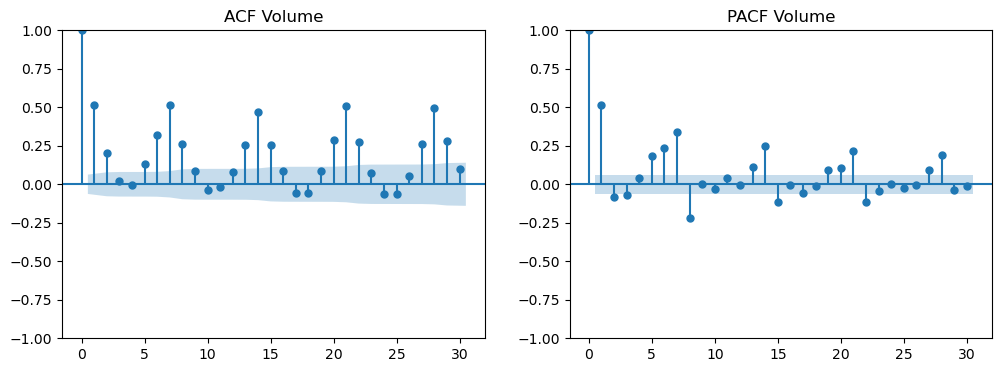

In [76]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

sm_api.graphics.tsa.plot_acf(df['Volume'], lags=30, ax=axes[0])
axes[0].set_title("ACF Volume")

sm_api.graphics.tsa.plot_pacf(df['Volume'], lags=30, ax=axes[1])
axes[1].set_title("PACF Volume")

plt.show()

The ACF plot confirms the seasonality in the time series, while the PACF plot shows 3-4 spikes outside the blue area, suggesting that lags 1, 2, 3, and possibly 4 have a significant direct effect on the target variable, and values after lag 4 remain within the blue area, indicating that additional lags don't add much predictive value.

In [77]:
def add_lagged_feature(df, feature_name, n_lags):
    lagged_data = df.copy()
    for lag in range(1, n_lags + 1):
        lagged_data[f'{feature_name}_lag{lag}'] = df[feature_name].shift(lag)
    
    lagged_data = lagged_data.dropna().reset_index(drop=True)
    
    return lagged_data

n_lags = 4
feature_to_lag = 'Volume'
df = add_lagged_feature(df, feature_to_lag, n_lags)

## Train/Validation/Test Split

To prevent overfitting and ensure a more objective assessment of the model, I will use a train/validation/test split for both Machine Learning and Deep Learning models.

In [106]:
X = df.drop("Volume", axis=1)
y = df["Volume"]

test_days = 50
X_train, X_test = X[:-test_days], X[-test_days:]
y_train, y_test = y[:-test_days], y[-test_days:]


val_days = 50

X_train, X_val = X_train[:-val_days], X_train[-val_days:]
y_train, y_val = y_train[:-val_days], y_train[-val_days:]

print("X_train shape:", X_train.shape)
print("X_val shape:", X_val.shape)
print("X_test shape:", X_test.shape)

X_train shape: (869, 30)
X_val shape: (50, 30)
X_test shape: (50, 30)


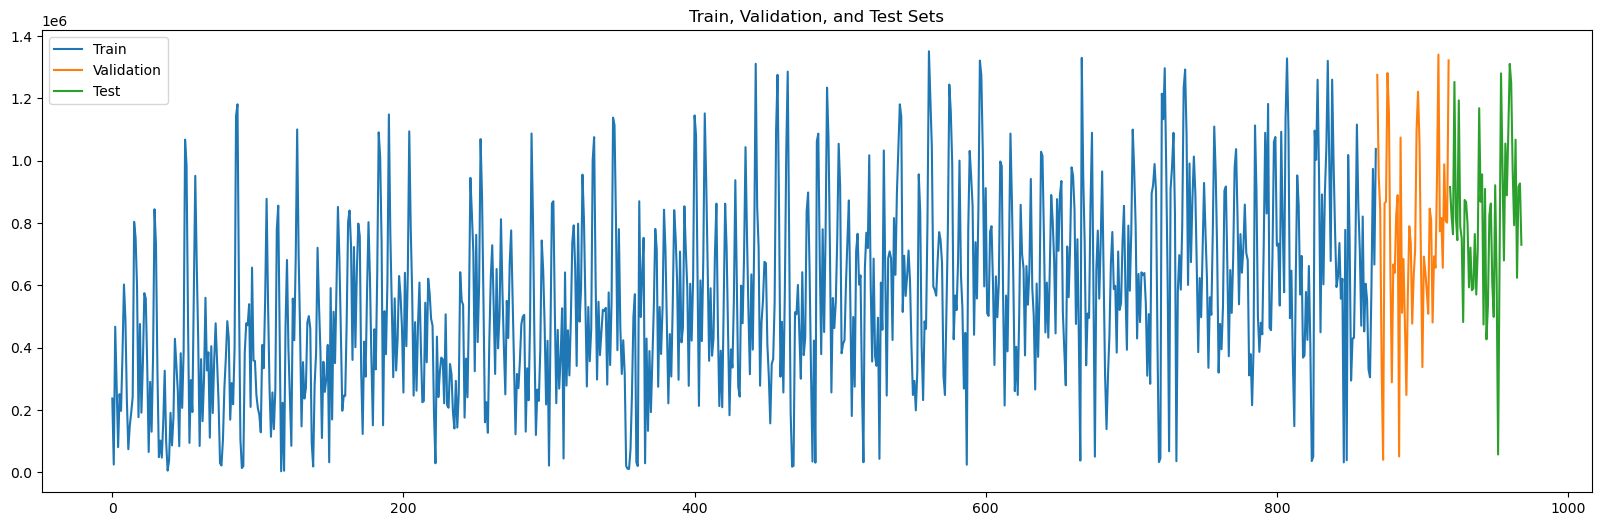

In [113]:
plt.figure(figsize=(20, 6))
plt.plot(X_train.index, y_train, label='Train')
plt.plot(X_val.index, y_val, label='Validation')
plt.plot(X_test.index, y_test, label='Test')
plt.legend()
plt.title('Train, Validation, and Test Sets')
plt.show()

In [114]:
scaler = MinMaxScaler()

num_columns = [
    column for column in df.columns
    if not column.endswith('_sin') and not column.endswith('_cos') and df[column].nunique() > 2
]

num_columns.remove("Volume")

X_train = X_train.copy()
X_test = X_test.copy()
X_val = X_val.copy()

X_train[num_columns] = scaler.fit_transform(X_train[num_columns])
X_test[num_columns] = scaler.transform(X_test[num_columns])
X_val[num_columns] = scaler.transform(X_val[num_columns])

I scaled all numeric features using MinMaxScaler, excluding the sine/cosine representations and boolean features with fewer than two unique values. The scaler was fitted only on the training data to prevent data leakage.

In [115]:
## For LGB model:
lgb_train = lgb.Dataset(X_train, y_train)
lgb_val = lgb.Dataset(X_val, y_val, reference=lgb_train)

params = {
    'objective': 'regression',  
    'metric': 'rmse',         
    'boosting_type': 'gbdt',
    'verbose': -1 
}

## Function to train and evaluate ML models

def train_and_evaluate_model(model, model_name):
    if model_name == "LightGBM":
        model = model.train(params, lgb_train, valid_sets=[lgb_train, lgb_val])
    elif model_name == "CatBoost":
        model.fit(X_train, y_train, eval_set=(X_val, y_val), use_best_model=True, logging_level='Silent')
    else:
        model.fit(X_train, y_train)
    
    y_pred = model.predict(X_val)

    mae = mean_absolute_error(y_val, y_pred)
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))

    plt.figure(figsize=(20, 6))
    plt.plot(y_val.index, y_val, label='Validation')
    plt.plot(y_val.index, y_pred, label='Forecast')
    plt.legend(loc='best')
    plt.title(f'{model_name} Model - Actual vs Forecast')
    plt.show()

    print(f"RMSE: {rmse:.4f}")
    print(f"MAE: {mae:.4f}")
    return rmse

## Decision Trees and Ensembles models

### LightGBM

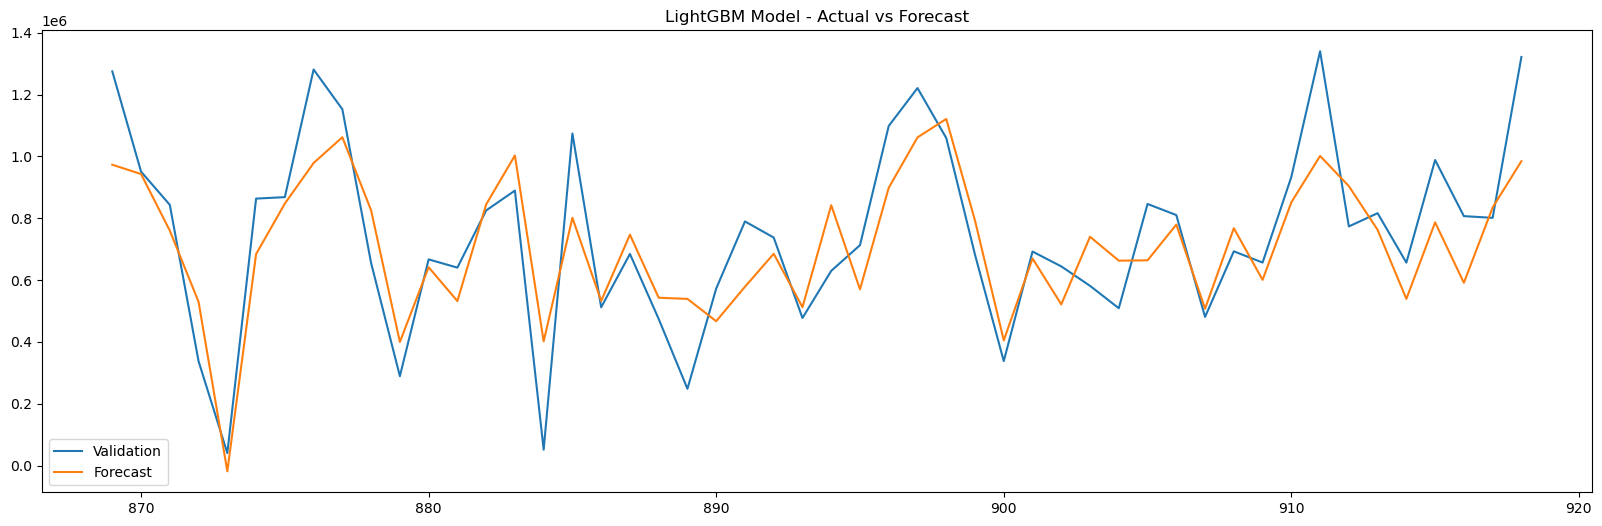

RMSE: 161583.9457
MAE: 130979.8721


In [116]:
rmse_lgb = train_and_evaluate_model(lgb, "LightGBM")

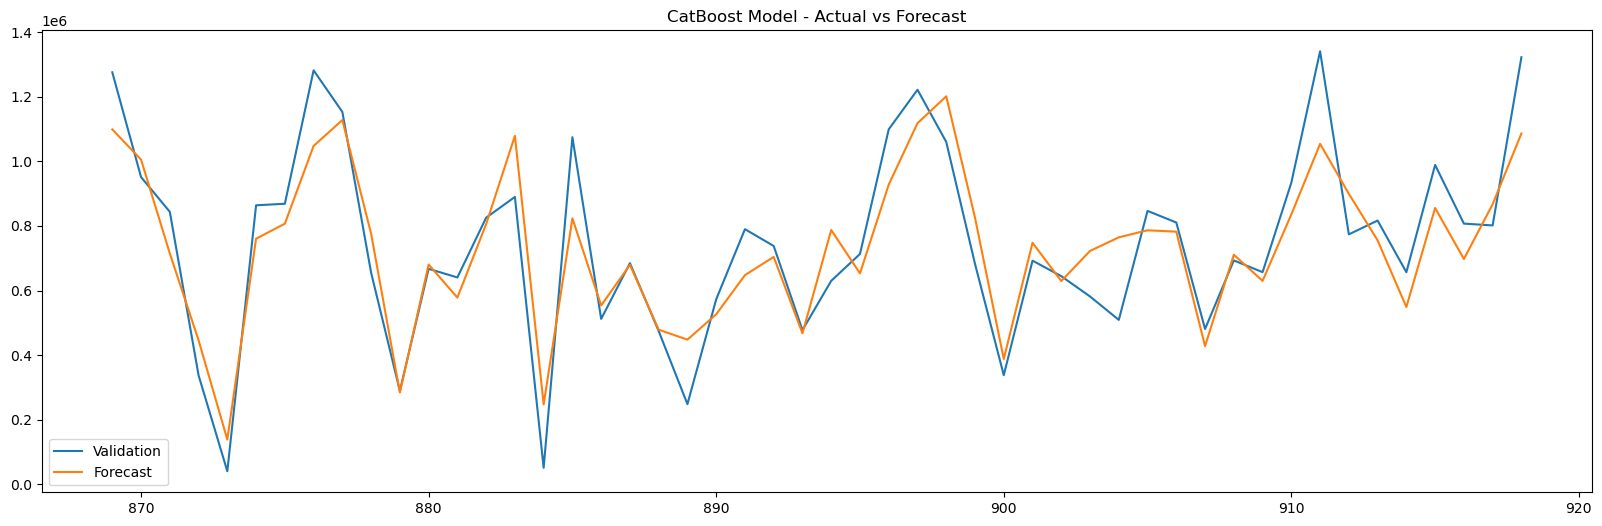

RMSE: 125239.9605
MAE: 100675.0516


In [117]:
cat = CatBoostRegressor(allow_writing_files=False)
rmse_cat = train_and_evaluate_model(cat, "CatBoost")

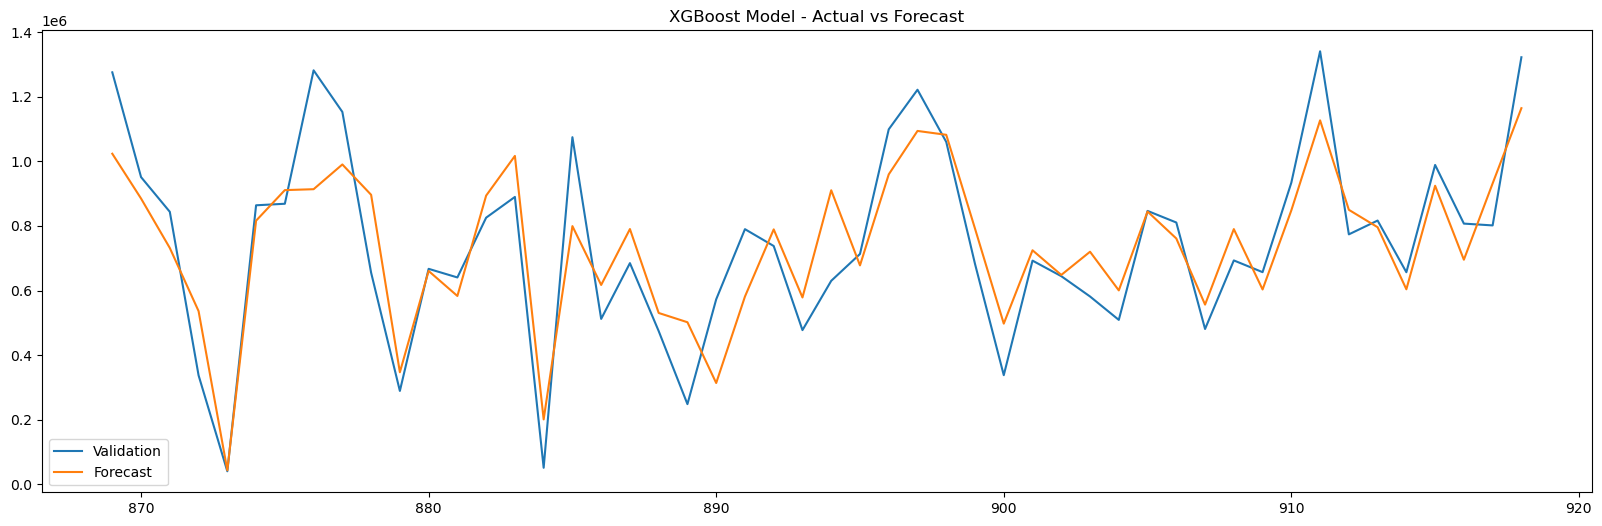

RMSE: 141792.2950
MAE: 114096.1273


In [118]:
xgb = XGBRegressor()
rmse_xgb = train_and_evaluate_model(xgb, "XGBoost")

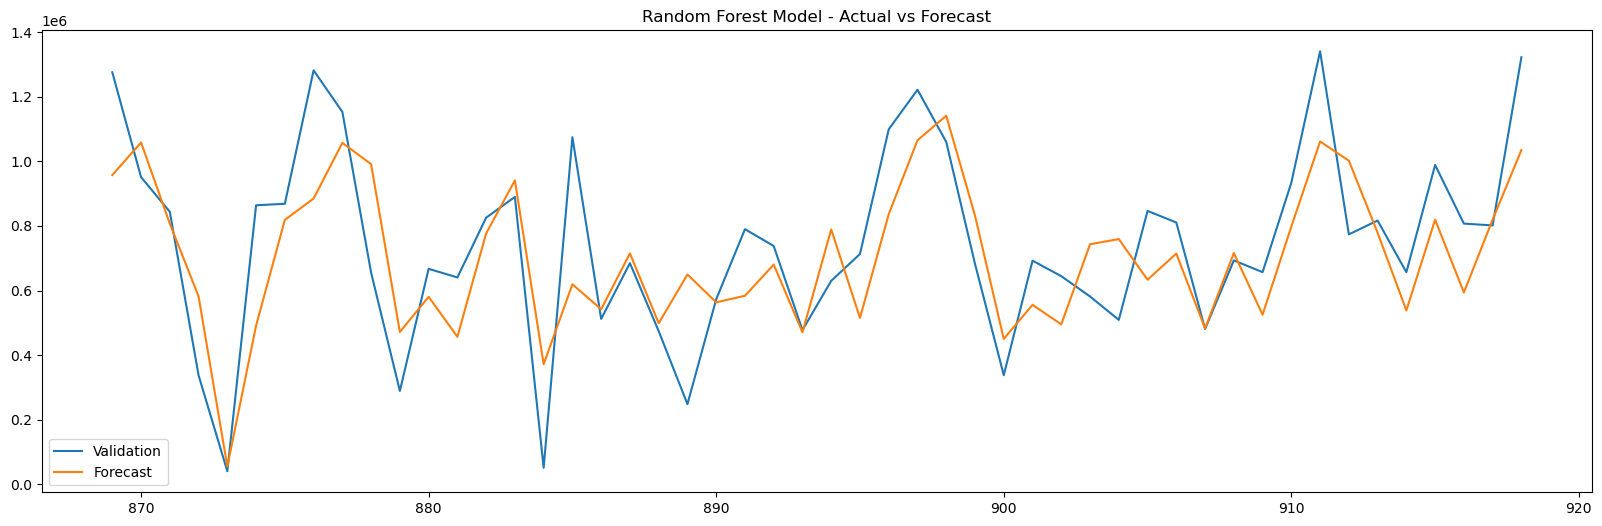

RMSE: 195736.7626
MAE: 156680.1188


In [119]:
rf = RandomForestRegressor()
rmse_rf = train_and_evaluate_model(rf, "Random Forest")

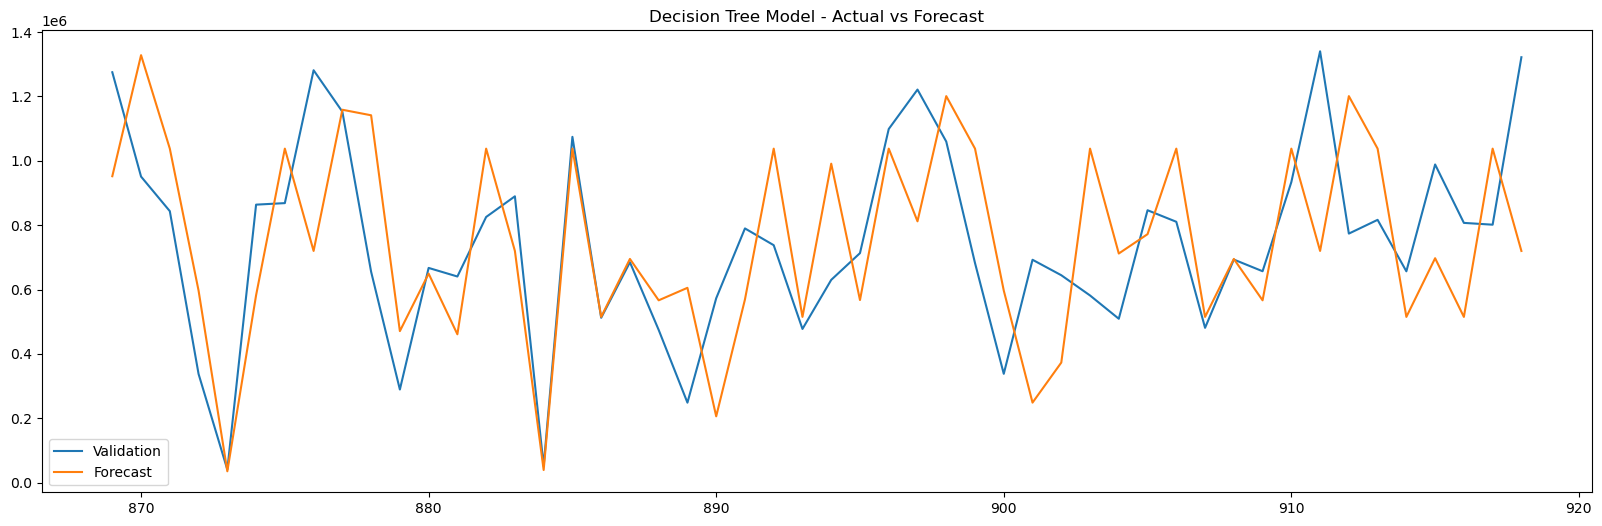

RMSE: 280108.9260
MAE: 226686.4600


In [120]:
tree = DecisionTreeRegressor()
rmse_tree = train_and_evaluate_model(tree, "Decision Tree")

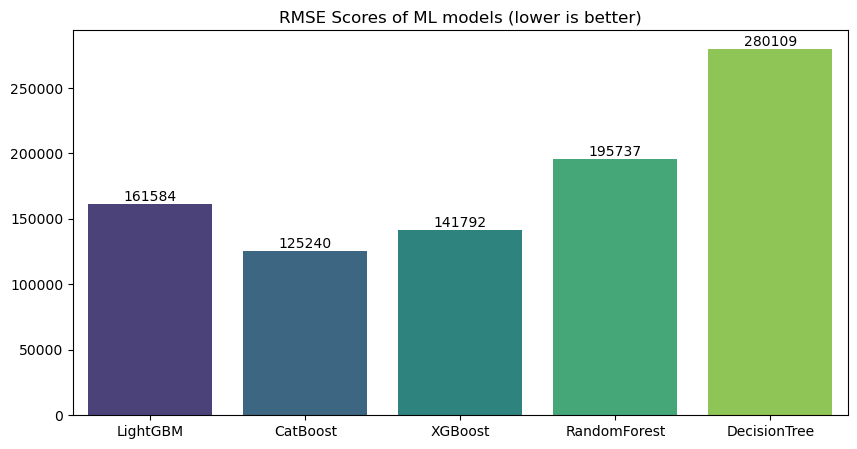

In [121]:
rmse_scores = [rmse_lgb, rmse_cat, rmse_xgb, rmse_rf, rmse_tree]

models = ["LightGBM", "CatBoost", "XGBoost", "RandomForest", "DecisionTree"]

plt.figure(figsize=(10, 5))
sns.barplot(x=models, y=rmse_scores, hue = models, palette="viridis")
for i, value in enumerate(rmse_scores):
    plt.text(i, value + 0.01, f'{value:.0f}', ha='center', va='bottom')
    
plt.title("RMSE Scores of ML models (lower is better)")
plt.show()

Most ML models outperformed SARIMA and Prophet, but their performance was still not satisfactory. The best model, CatBoost, achieved an RMSE of 125,240.

## Deep Learning models

I will train 3 neural networks using architectures based on CNN, LSTM, and GRU layers. For all these networks, the training, validation and testing sets will be reshaped into the format (samples, timesteps, features), where timesteps represent the number of past time points included for the neural network to analyze simultaneously. I will use a 4-day window, corresponding to the number of lags.

In [122]:
time_steps = 4

y_train = scaler.fit_transform(y_train.to_numpy().reshape(-1, 1))
y_test = scaler.transform(y_test.to_numpy().reshape(-1, 1))
y_val = scaler.transform(y_val.to_numpy().reshape(-1, 1))

def create_sequences(features, target, time_steps):
    X, y = [], []
    for i in range(len(features) - time_steps):
        X.append(features[i:i + time_steps])
        y.append(target.iloc[i] if isinstance(target, pd.Series) else target[i])
    return np.array(X), np.array(y)

X_train, y_train = create_sequences(X_train, y_train, time_steps)
X_test, y_test = create_sequences(X_test, y_test, time_steps)
X_val, y_val = create_sequences(X_val, y_val, time_steps)

y_train = y_train.squeeze()
y_test = y_test.squeeze()  
y_val = y_val.squeeze()

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape) 
print("X_val shape:", X_val.shape)

X_train shape: (865, 4, 30)
y_train shape: (865,)
X_test shape: (46, 4, 30)
y_test shape: (46,)
X_val shape: (46, 4, 30)


In [123]:
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)

In [191]:
class InpostDataset(TensorDataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]
    

train_dataset = InpostDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

In [125]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [126]:
## Function to evaluate the model

def evaluate_model(model, model_name, X_val_tensor):
    model.eval()

    X_val_tensor = X_val_tensor.to(device)

    with torch.no_grad():
        if model_name == "CNN":
            y_pred_scaled = model(X_val_tensor.permute(0,2,1)).cpu().numpy()
        else:
            y_pred_scaled = model(X_val_tensor).cpu().numpy()
        
    y_pred = scaler.inverse_transform(y_pred_scaled).squeeze()
    y_val_original = scaler.inverse_transform(y_val.reshape(-1, 1)).squeeze()

    mae = mean_absolute_error(y_val_original, y_pred)
    rmse = np.sqrt(mean_squared_error(y_val_original, y_pred))

    plt.figure(figsize=(20, 6))
    plt.plot(range(len(y_val_original)), y_val_original, label="Actual")
    plt.plot(range(len(y_val_original)), y_pred, label="Forecast")
    plt.xlabel("Sample")
    plt.ylabel("Value")
    plt.title(f"{model_name} - Actual vs Forecast")
    plt.legend(loc="best")
    plt.show()

    print(f"RMSE: {rmse:.4f}")
    print(f"MAE: {mae:.4f}")

    return rmse

## CNN model
<img height = 600, width = 1000, src = "https://ik.imagekit.io/upgrad1/abroad-images/imageCompo/images/unnamed8PDPDZ_1_1ZBHFR.webp?pr-true" alt = "cnn architecture">

Convolutional Neural Networks (CNNs) are a class of deep learning models originally developed for image processing tasks but have proven effective for various types of structured data, including time series. CNNs are particularly good at capturing local patterns and spatial hierarchies through the use of convolutional filters.

Key Components of a CNN Model:
- Convolutional Layer: Applies filters (kernels) to detect local features or patterns in the input data.
- Activation Function (e.g., ReLU): Introduces non-linearity into the model, allowing it to learn complex relationships.
- Pooling Layer: Reduces the dimensionality of feature maps while retaining important information, helping prevent overfitting.
- Fully Connected Layer: Maps learned features to the output, often used in classification or regression tasks.

In the context of time series forecasting, CNNs can efficiently detect short-term trends, seasonality, and repeated patterns by sliding filters over time steps. They are particularly useful when data has spatial-temporal structure or localized dependencies.

Here, I will build a simple CNN model consisting of one convolutional layer with 100 filters, followed by a pooling layer, a dropout layer with a rate of 0.5, a fully connected layer with 300 neurons, and an output layer. The model will be trained using the Adam optimizer with a learning rate of 0.001.

In [192]:
torch.manual_seed(seed)


class CNNmodel(nn.Module):
    def __init__(self):
        super(CNNmodel, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=X_train_tensor.shape[2], out_channels=100, kernel_size=2)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool1d(kernel_size=1)
        self.dropout = nn.Dropout(0.5)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(100 * 3, 50) 
        self.fc2 = nn.Linear(50, 1)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.pool(x)
        x = self.dropout(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x
    

model_cnn = CNNmodel().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model_cnn.parameters(), lr=0.001)
n_epochs = 100

for epochs in range(n_epochs):
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        output = model_cnn(X_batch.permute(0,2,1))
        loss = criterion(output, y_batch)
        loss.backward()
        optimizer.step()
    if epochs % 10 == 0:
        print(f"Epoch: {epochs}, Loss: {loss.item()}")

Epoch: 0, Loss: 0.009088462218642235
Epoch: 10, Loss: 0.0003969461831729859
Epoch: 20, Loss: 0.0011304877698421478
Epoch: 30, Loss: 0.016073646023869514
Epoch: 40, Loss: 0.0009297552751377225
Epoch: 50, Loss: 0.0006075464771129191
Epoch: 60, Loss: 8.501177217112854e-05
Epoch: 70, Loss: 0.00046329593169502914
Epoch: 80, Loss: 0.0035550410393625498
Epoch: 90, Loss: 0.00023966212756931782


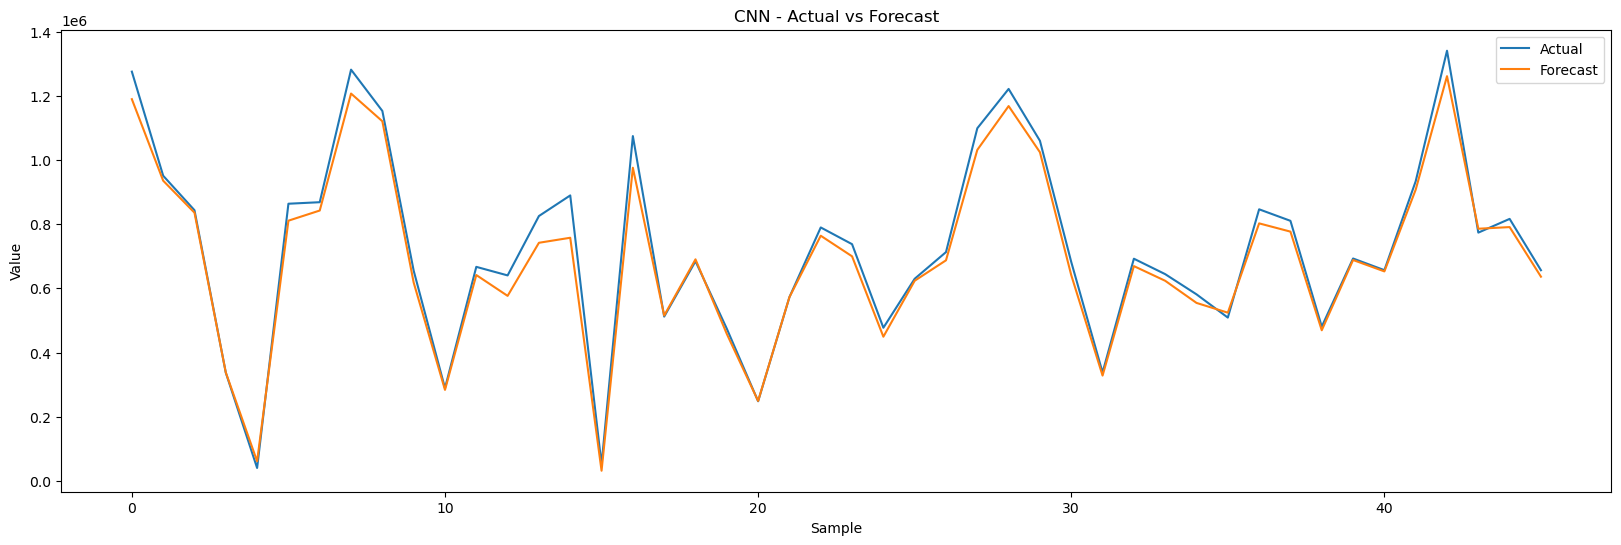

RMSE: 43310.3140
MAE: 32246.7705


In [193]:
rmse_cnn = evaluate_model(model_cnn, "CNN", X_val_tensor)

The plot and metrics show that the basic CNN model achieved significantly better performance—several times better—than any previous model. However, this is not the best achievable predictive performance; there are models specifically designed for time series forecasting that can capture dependencies more effectively.

## LSTM model

<img src = "https://media.licdn.com/dms/image/v2/D5612AQH7ywLf6xH_rA/article-cover_image-shrink_720_1280/article-cover_image-shrink_720_1280/0/1690356194969?e=2147483647&v=beta&t=S-frcgtTyzrBWZ0K3K_GqK8dZ6OGA5oPtLzIRwRG74M" alt = "lstm_layer">

Long Short-Term Memory (LSTM) is a specialized architecture of recurrent neural networks (RNNs), designed to effectively capture long-term dependencies in sequential data. It was developed to address the vanishing gradient problem that traditional RNNs often encounter during training.

Key Components of an LSTM Cell:
- Forget Gate: Determines which information to discard from the cell state.
- Input Gate: Determines which new information to store in the cell state.
- Cell State Update: Updates the cell state based on the input and forget gates.
- Output Gate: Controls which part of the cell state is passed to the output.

LSTM models are widely used in applications such as time series forecasting, speech recognition, text generation, and machine translation. Although they have largely replaced standard RNNs, they are now being surpassed by more advanced architectures like Transformers, which offer superior predictive performance.

I will train an LSTM model with a basic architecture to compare it with a more simplified one - GRU. Initially, the model will include one LSTM layer with 50 hidden neurons, an appropriate output layer, 100 training epochs, and the Adam optimizer with a learning rate of 0.001.

In [194]:
torch.manual_seed(seed)

class LSTMmodel(nn.Module):
    def __init__(self):
        super(LSTMmodel, self).__init__()
        self.lstm = nn.LSTM(input_size=X_train_tensor.shape[2], hidden_size=50, num_layers=1, batch_first=True)
        self.fc1 = nn.Linear(50, 1)

    def forward(self, x):
        _, (h, _) = self.lstm(x)
        x = self.fc1(h[-1])
        return x
    

model_lstm = LSTMmodel().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model_lstm.parameters(), lr=0.001)
n_epochs = 100

for epochs in range(n_epochs):
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        output = model_lstm(X_batch)
        loss = criterion(output, y_batch)
        loss.backward()
        optimizer.step()
    if epochs % 10 == 0:
        print(f"Epoch: {epochs}, Loss: {loss.item()}")

Epoch: 0, Loss: 0.0742572471499443
Epoch: 10, Loss: 0.00448613939806819
Epoch: 20, Loss: 8.072349010035396e-05
Epoch: 30, Loss: 1.4547140381182544e-05
Epoch: 40, Loss: 0.0006009977660141885
Epoch: 50, Loss: 0.0007359774899668992
Epoch: 60, Loss: 2.36916293943068e-05
Epoch: 70, Loss: 0.00015277050260920078
Epoch: 80, Loss: 1.1136536159028765e-05
Epoch: 90, Loss: 1.864331352408044e-05


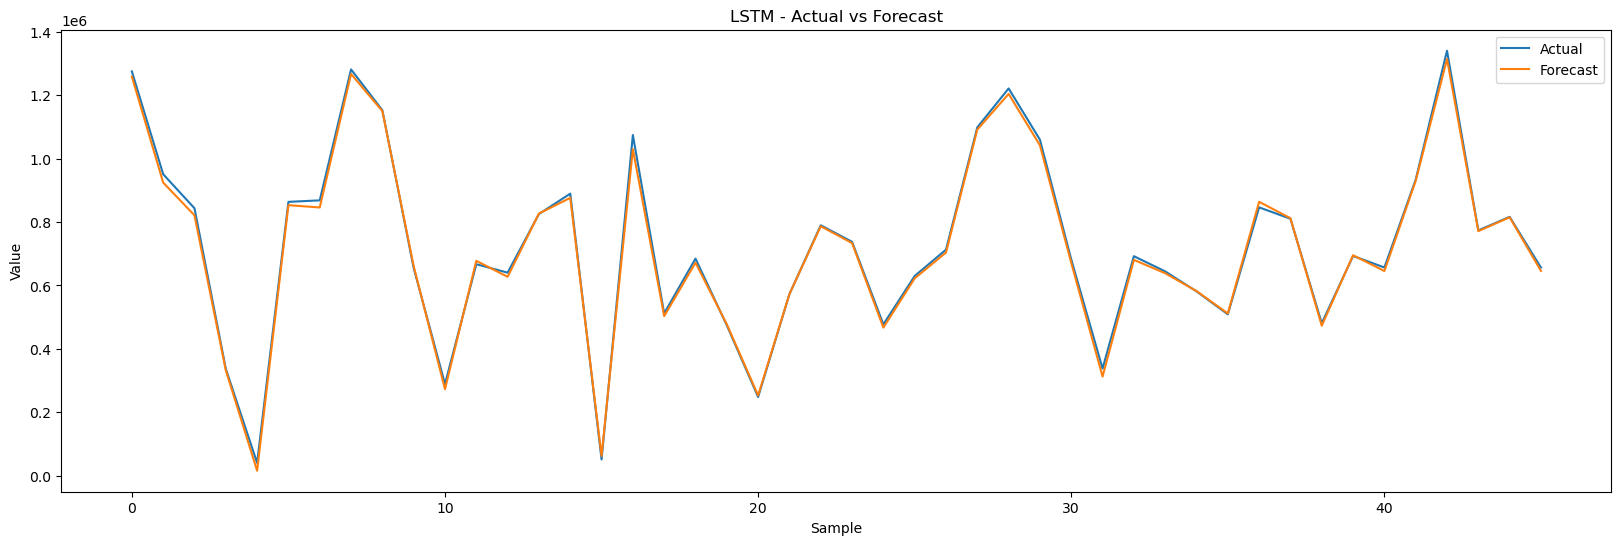

RMSE: 14175.9574
MAE: 11041.2916


In [195]:
rmse_lstm = evaluate_model(model_lstm, "LSTM", X_val_tensor)

The predictions are significantly better than those of the previous models, with the RMSE reduced from 43,000 to 14,000. This demonstrates the strong performance of LSTM models for time series forecasting.

## GRU model

<img src = "https://www.researchgate.net/publication/363488545/figure/fig1/AS:11431281084097340@1663029319078/Gated-Recurrent-Unit-GRU.png" alt="gru_layer">

Gated Recurrent Unit (GRU) is a type of recurrent neural network (RNN) architecture designed to capture long-term dependencies in sequential data. It was introduced as a simplified version of the LSTM to address the vanishing gradient problem while being more computationally efficient.

Key Components of a GRU Cell:
- Update Gate: Controls how much of the previous state should be carried forward and how much of the new information should be incorporated into the current state.
- Reset Gate: Determines how much of the previous state should be ignored when calculating the candidate hidden state.
- Candidate Hidden State: The potential new state that could be added to the current state, adjusted by the reset gate.
- Final Hidden State: A weighted sum of the previous hidden state and the candidate hidden state, controlled by the update gate.

GRU models are widely used in applications such as time series forecasting, speech recognition, and machine translation, providing a simpler and faster alternative to LSTMs

I will use the same architecture and hyperparameters as in the LSTM model

In [196]:
torch.manual_seed(seed)

class GRUmodel(nn.Module):
    def __init__(self):
        super(GRUmodel, self).__init__()
        self.gru = nn.GRU(input_size=X_train_tensor.shape[2], hidden_size=50, num_layers=1, batch_first=True)
        self.fc1 = nn.Linear(50, 1)

    def forward(self, x):
        _, h = self.gru(x)
        x = self.fc1(h[-1])
        return x
    

model_gru = GRUmodel().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model_gru.parameters(), lr=0.001)
n_epochs = 100

for epochs in range(n_epochs):
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        output = model_gru(X_batch)
        loss = criterion(output, y_batch)
        loss.backward()
        optimizer.step()
        
    if epochs % 10 == 0:
        print(f"Epoch: {epochs}, Loss: {loss.item()}")

Epoch: 0, Loss: 0.06243671476840973
Epoch: 10, Loss: 0.0011061792029067874
Epoch: 20, Loss: 0.00013272340584080666
Epoch: 30, Loss: 2.9839529815944843e-05
Epoch: 40, Loss: 1.584831466061587e-07
Epoch: 50, Loss: 2.316282370884437e-05
Epoch: 60, Loss: 3.150542511320964e-07
Epoch: 70, Loss: 2.9317465305211954e-05
Epoch: 80, Loss: 1.8104112768924097e-06
Epoch: 90, Loss: 1.575307032908313e-05


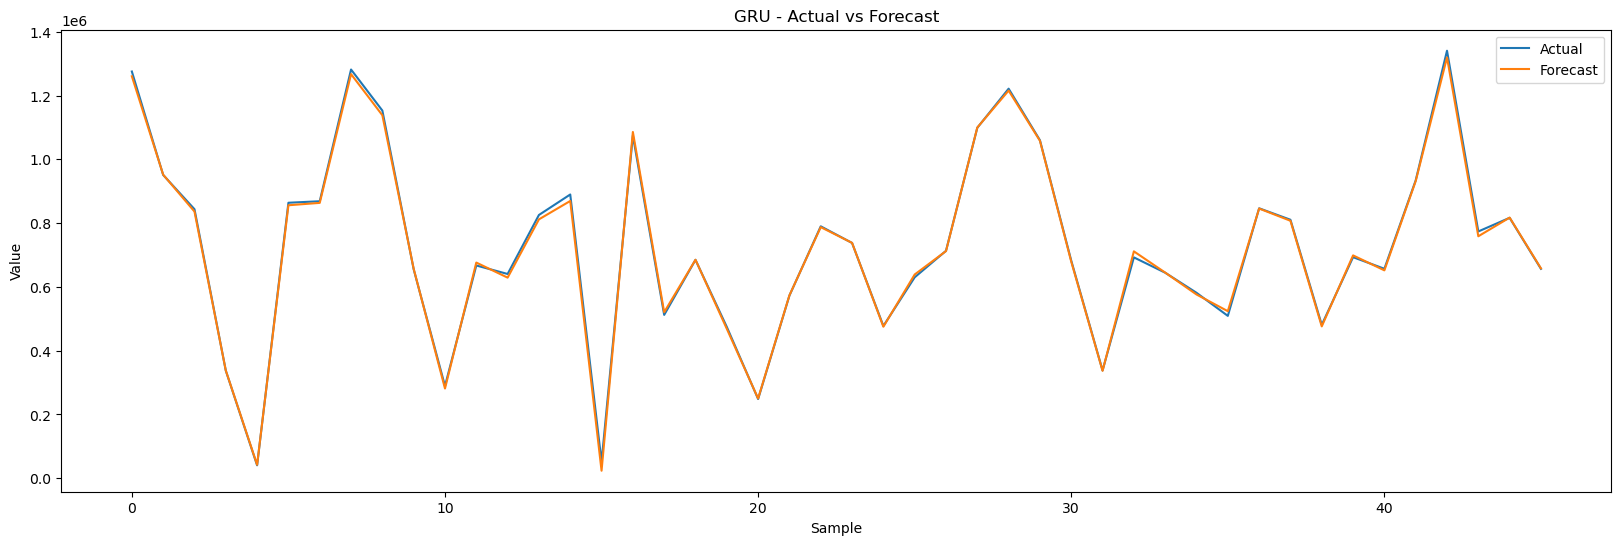

RMSE: 9541.3483
MAE: 6825.9976


In [197]:
rmse_gru = evaluate_model(model_gru, "GRU", X_val_tensor)

The GRU model achieved better performance than the LSTM model.

In [198]:
total_params = sum(p.numel() for p in model_lstm.parameters())
print(f"Total parameters in LSTM model: {total_params}")

total_params = sum(p.numel() for p in model_gru.parameters())
print(f"Total parameters in GRU model: {total_params}")

Total parameters in LSTM model: 16451
Total parameters in GRU model: 12351


While having fewer parameters, the GRU model outperforms the LSTM model with the same architecture and hyperparameters in terms of predictive performance. Since the GRU model with the base architecture is the best-performing among all the tested models, I will focus on hyperparameter tuning exclusively for it to identify the optimal architecture.

## GRU Model - Hyperparameter Tuning

In neural networks, there are numerous hyperparameters to tune, but I will focus on the following key ones:
- Number of layers
- Number of neurons in the GRU layer
- Number of epochs
- Learning rate for the optimizer
- Dropout rate (to prevent overfitting)

This approach will help identify the best architecture, leading to the most accurate predictive performance.

In [161]:
results = pd.DataFrame(columns=["num_layers", "hidden_size", "num_epochs", "lr", "dropout", "RMSE_val", "RMSE_train"])
device = "cuda"
criterion = nn.MSELoss()

def train_gru_model(X_train_tensor, X_val_tensor, num_layers=1, hidden_size=50, num_epochs=100, lr=0.001, dropout=0.0):

    ## Set seed for consistency
    torch.manual_seed(seed)

    ## Check if the model has already been trained with the same parameters
    if ((results["num_layers"] == num_layers) & 
    (results["hidden_size"] == hidden_size) & 
    (results["num_epochs"] == num_epochs) &
    (results["lr"] == lr) &
    (results["dropout"] == dropout)).any():
        return results


    ## Define the Architecture
    class GRUmodel(nn.Module):
        def __init__(self):
            super(GRUmodel, self).__init__()

            self.gru = nn.GRU(
                input_size=X_train_tensor.shape[2], 
                hidden_size=hidden_size, 
                num_layers=num_layers, 
                dropout=dropout if num_layers > 1 else 0.0, 
                batch_first=True
                )
            
            self.dropout = nn.Dropout(dropout)
            self.fc1 = nn.Linear(hidden_size, 1)

        def forward(self, x):
            _, h = self.gru(x)
            x = self.dropout(h[-1])
            x = self.fc1(x)
            return x
                
    ## Initialize the model and optimizer
    model = GRUmodel().to(device)
    optimizer_fn = optim.Adam(model.parameters(), lr=lr)

    ## Train model
    for epochs in range(num_epochs):
        model.train()
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer_fn.zero_grad()
            output = model(X_batch)
            loss = criterion(output, y_batch)
            loss.backward()
            optimizer_fn.step()

    ## Evaluate on Val set
    model.eval()

    X_val_tensor = X_val_tensor.to(device)
    with torch.no_grad():
        y_pred_scaled = model(X_val_tensor).cpu().numpy()

    y_pred = scaler.inverse_transform(y_pred_scaled).squeeze()
    y_val_original = scaler.inverse_transform(y_val.reshape(-1, 1)).squeeze()
    rmse_val = round(np.sqrt(mean_squared_error(y_val_original, y_pred)),2)
    
    ## Evaluate on train set
    X_train_tensor = X_train_tensor.to(device)
    with torch.no_grad():
        y_pred_scaled = model(X_train_tensor).cpu().numpy()

    y_pred = scaler.inverse_transform(y_pred_scaled).squeeze()
    y_train_original = scaler.inverse_transform(y_train.reshape(-1, 1)).squeeze()
    rmse_train = round(np.sqrt(mean_squared_error(y_train_original, y_pred)),2)

    results.loc[len(results)] = [num_layers, hidden_size, num_epochs, lr, dropout, rmse_val, rmse_train]
    return results

In [164]:
param_grid = {
    'num_layers': [1, 2, 3],
    'hidden_size': [200, 300],
    'num_epochs': [200, 300, 400],
    'lr': [0.0001, 0.0005, 0.001],
    'dropout': [0.0, 0.3, 0.5]
}

param_combinations = list(itertools.product(
    param_grid['num_layers'], 
    param_grid['hidden_size'], 
    param_grid['num_epochs'], 
    param_grid['lr'],
    param_grid['dropout']
))

for num_layers, hidden_size, num_epochs, lr, dropout in tqdm(param_combinations, desc="Hyperparameter Search"):
    results = train_gru_model(X_train_tensor, X_val_tensor, num_layers, hidden_size, num_epochs, lr, dropout)

Hyperparameter Search: 100%|██████████| 162/162 [49:06<00:00, 18.19s/it]


In [206]:
results.to_csv("hyperparameter_search_results.csv", index=False)
results.sort_values(by="RMSE_val").head(10)

,num_layers,hidden_size,num_epochs,lr,dropout,RMSE_val,RMSE_train
48,1.0,300.0,400.0,0.0005,0.0,2304.93,2466.35
51,1.0,300.0,400.0,0.0010,0.0,3151.78,3571.57
24,1.0,200.0,400.0,0.0010,0.0,3344.91,2932.04
99,2.0,300.0,400.0,0.0001,0.0,3595.23,4253.33
45,1.0,300.0,400.0,0.0001,0.0,3782.48,2932.04
75,2.0,200.0,400.0,0.0005,0.0,3808.92,1754.87
21,1.0,200.0,400.0,0.0005,0.0,4041.62,4616.01
15,1.0,200.0,300.0,0.0010,0.0,4265.06,6027.73
30,1.0,300.0,200.0,0.0005,0.0,4337.56,3302.59
3,1.0,200.0,200.0,0.0005,0.0,4339.11,3949.72


In [200]:
rmse_gru = results["RMSE_val"].min()
print(f"Best RMSE: {rmse_gru:.4f}")

best_params = results.loc[results["RMSE_val"].idxmin()]
print(f"The best parameters: num_layers={best_params['num_layers']}, "
      f"hidden_size={best_params['hidden_size']}, "
      f"num_epochs={best_params['num_epochs']}, "
      f"lr={best_params['lr']}, "
      f"dropout={best_params['dropout']}")

Best RMSE: 2304.9300
The best parameters: num_layers=1.0, hidden_size=300.0, num_epochs=400.0, lr=0.0005, dropout=0.0


## Comparison of All Models by RMSE on the Validation Set

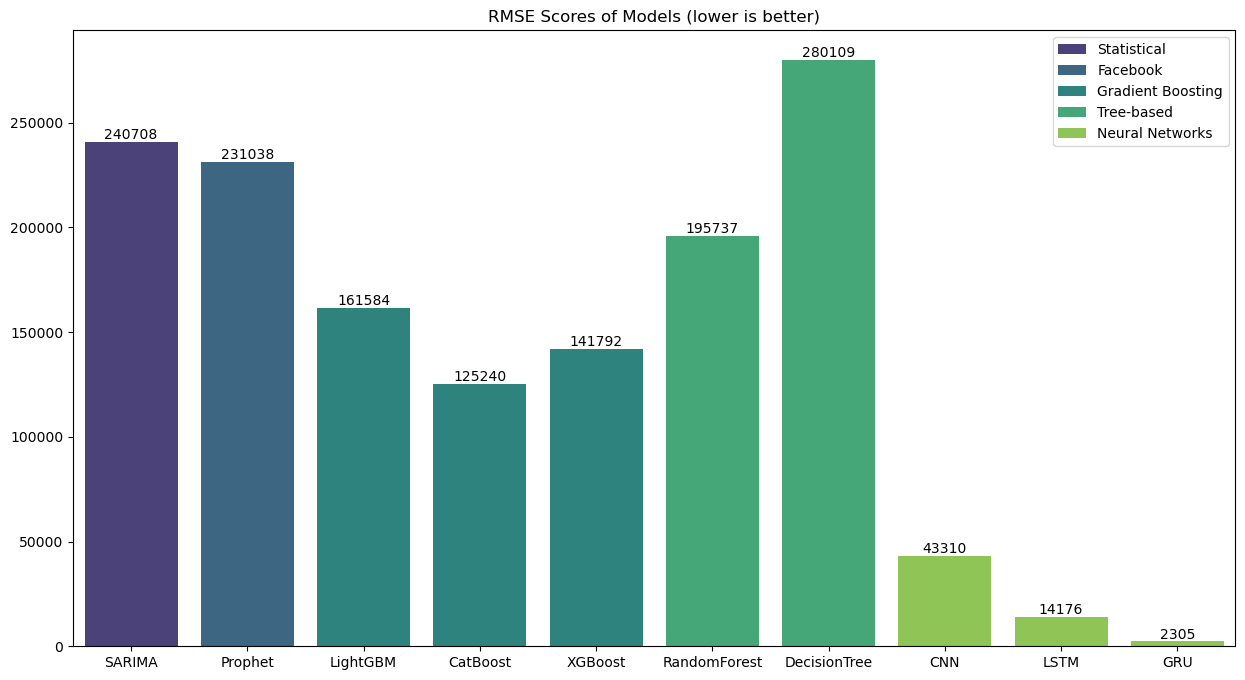

In [201]:
rmse_scores = [rmse_sarima, rmse_prophet, rmse_lgb, rmse_cat, rmse_xgb, rmse_rf, rmse_tree, rmse_cnn, rmse_lstm, rmse_gru]

models_types = ["Statistical", "Facebook", "Gradient Boosting", "Gradient Boosting", "Gradient Boosting", "Tree-based", "Tree-based", "Neural Networks", "Neural Networks", "Neural Networks"]

models = ["SARIMA", "Prophet", "LightGBM", "CatBoost", "XGBoost", "RandomForest", "DecisionTree", "CNN", "LSTM", "GRU"]

plt.figure(figsize=(15, 8))
sns.barplot(x=models, y=rmse_scores, hue = models_types, palette="viridis")
for i, value in enumerate(rmse_scores):
    plt.text(i, value + 0.01, f'{value:.0f}', ha='center', va='bottom')
    
plt.title("RMSE Scores of Models (lower is better)")
plt.show()

Neural networks, particularly GRU (2305) (After Hyperparameter Tuning) and LSTM (14,176), significantly outperform other models, showcasing their effectiveness. Gradient boosting models, such as CatBoost (125,240), also demonstrate strong performance, while tree-based and statistical models lag behind. Among these, the Decision Tree model (280,109) performs the worst. This comparison underscores the superiority of recurrent neural networks (RNNs) for time series forecasting.

## Evaluating the GRU Model with Optimal Parameters

After hyperparameter tuning, the following optimal parameters were selected:
- Number of layers: 1
- Number of neurons in the GRU layer: 300
- Number of epochs: 400
- Learning rate for the optimizer: 0.0005
- Dropout rate: 0

I will now train the final model using these parameters and evaluate its performance on the test set, which has not been used in any previous stages.

In [202]:
torch.manual_seed(seed)

losses = []

num_layers = 1
hidden_size = 300
num_epochs = 400
lr = 0.0005
dropout = 0

class GRUmodel(nn.Module):
    def __init__(self):
        super(GRUmodel, self).__init__()
        
        self.gru = nn.GRU(
            input_size = X_train_tensor.shape[2], 
            hidden_size = hidden_size, 
            num_layers = num_layers, 
            dropout = dropout if num_layers > 1 else 0.0, 
            batch_first = True
            )
        
        self.dropout = nn.Dropout(dropout)
        self.fc1 = nn.Linear(hidden_size, 1)

    def forward(self, x):
        _, h = self.gru(x)
        x = self.dropout(h[-1])
        x = self.fc1(x)
        return x
            
best_model = GRUmodel().to(device)
optimizer_fn = optim.Adam(best_model.parameters(), lr=lr)

for epochs in range(num_epochs):
    best_model.train()
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer_fn.zero_grad()
        output = best_model(X_batch)
        loss = criterion(output, y_batch)
        loss.backward()
        optimizer_fn.step()
    losses.append(loss.item())

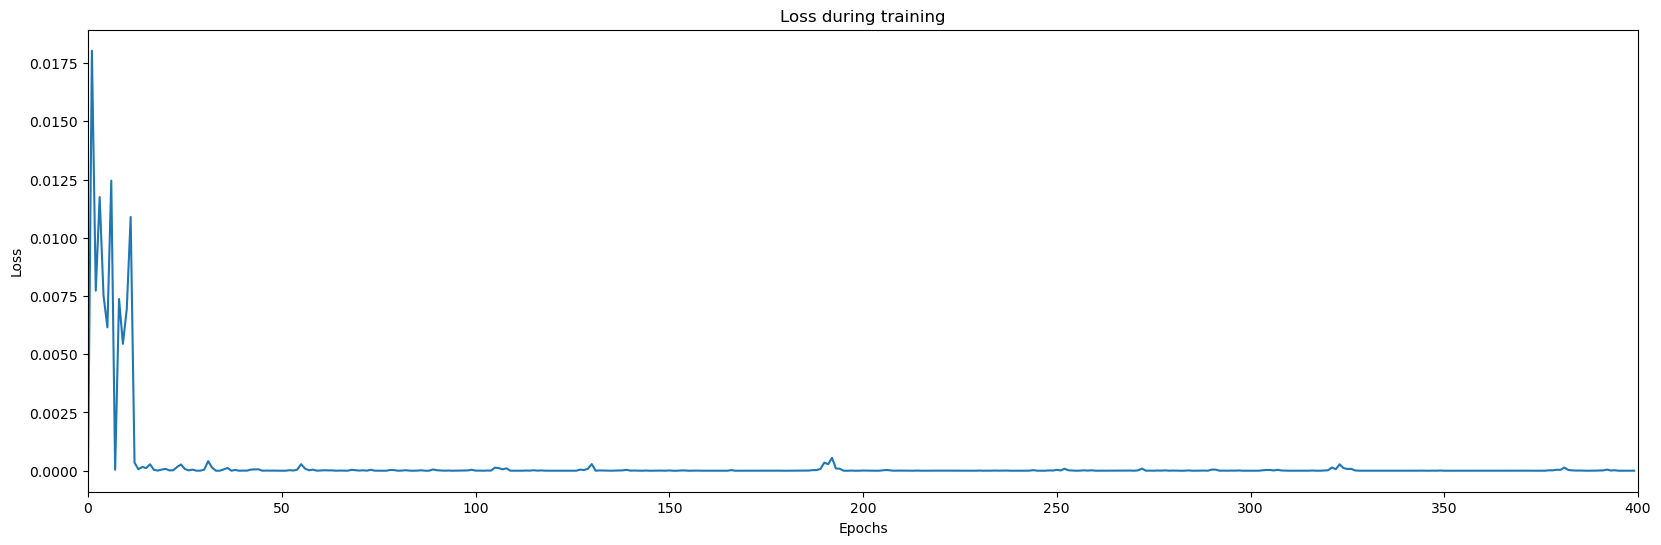

In [203]:
plt.figure(figsize=(20, 6))
plt.plot(losses)
plt.title("Loss during training")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.xlim(0, 400)
plt.show()

## The best model evaluation on the Test set

In [205]:
best_model.eval()

X_test_tensor = X_test_tensor.to(device)

with torch.no_grad():
    y_pred_scaled = best_model(X_test_tensor).cpu().numpy()

y_pred = scaler.inverse_transform(y_pred_scaled).squeeze()
y_test_original = scaler.inverse_transform(y_test.reshape(-1, 1)).squeeze()
rmse_test = round(np.sqrt(mean_squared_error(y_test_original, y_pred)),2)
mae_test = round(mean_absolute_error(y_test_original, y_pred),2)
mape_test = mean_absolute_percentage_error(y_test_original, y_pred)
r2_test = r2_score(y_test_original, y_pred)

print("RMSE:", round(rmse_test,2))
print("MAE:", round(mae_test,2))
print("MAPE:", round(mape_test*100,2), "%")
print("R2:", round(r2_test, 2))

round(df.describe().Volume)

RMSE: 1532.46
MAE: 1232.35
MAPE: 0.18 %
R2: 1.0


count        969.0
mean      575047.0
std       300201.0
min         3729.0
25%       358020.0
50%       557998.0
75%       771398.0
max      1351117.0
Name: Volume, dtype: float64

The model's performance metrics on the Test Set are as follows: RMSE is 1532, MAE is 1232, $R^2$ is 1.0, and MAPE is 0.18%. The target variable, *Volume*, has a mean of 577,047 and a standard deviation of 300,201, with values ranging from 3,729 to 1,351,117. These results indicate relatively small prediction errors compared to the data scale.

## Conclusion

In conclusion, this project successfully optimized InPost logistics by developing a robust predictive model for forecasting daily parcel shipments. By integrating multiple data sources, including historical shipment volumes, client forecasts, date-specific attributes, and weather conditions, the model significantly improved planning accuracy. Additionally, the GRU model outperformed other algorithms, achieving the best performance in terms of forecasting accuracy.